In [1]:
# # 在导入任何库之前添加
# import os
# os.environ["TORCH_COMPILE_DEBUG"] = "1"
# os.environ["TORCH_INDUCTOR_DISABLE_CUSTOM_PASSES"] = "1"
# 首先导入 torch 及其所有子模块
import torch
import torch.nn as nn
import torch.optim as optim

# 然后导入其他库
import pandas as pd
import numpy as np
import os
import re
import json
import time
import requests
from datetime import datetime
from typing import List, Dict, Tuple, Optional
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import platform
# 最后导入 transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from textblob import TextBlob


# 添加以下导入
try:
    from IPython.display import display, Image
    in_notebook = True
except ImportError:
    in_notebook = False

# 设置matplotlib以支持中文和保存图像
plt.rcParams['figure.max_open_warning'] = 50  # 允许更多图形
# 设置中文字体支持 - 针对Mac环境
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = ['SimHei','Arial Unicode MS']
else:  # Windows或Linux
    plt.rcParams['font.family'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

In [2]:
import pandas as pd
import numpy as np
import os
import re
import json
import time
import requests
import torch
from datetime import datetime
from typing import List, Dict, Tuple, Optional
from tqdm.auto import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

# 创建结果保存目录结构
RESULTS_DIR = "生成结果"
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
    print(f"已创建结果保存目录: {os.path.abspath(RESULTS_DIR)}")
else:
    print(f"使用现有结果保存目录: {os.path.abspath(RESULTS_DIR)}")


# 设置关键词保存的文件夹
KEYWORD_DIR = os.path.join(RESULTS_DIR, "product_keywords")
if not os.path.exists(KEYWORD_DIR):
    os.makedirs(KEYWORD_DIR)
    print(f"已创建关键词目录: {os.path.abspath(KEYWORD_DIR)}")
else:
    print(f"使用现有关键词目录: {os.path.abspath(KEYWORD_DIR)}")

# 全局设置
API_KEY = "sk-2ea9416b45e04af6b6aa72d3c2ade52f"  # 输入您的qwen API密钥

# 如果未设置API_KEY，尝试从环境变量获取
if not API_KEY:
    API_KEY = os.environ.get("QWEN_API_KEY", "")

# 检查GPU状态
print(f"CUDA可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU型号: {torch.cuda.get_device_name(0)}")

# 检查MPS (Mac M1/M2 GPU)
try:
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print("✅ MPS可用 - 将使用M1/M2 GPU加速")
        device = "mps"
    else:
        print("❌ MPS不可用")
        device = "cuda" if torch.cuda.is_available() else "cpu"
except:
    print("❓ 无法检测MPS状态")
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"将使用设备: {device}")


使用现有结果保存目录: C:\Users\admin\OneDrive\斗兽场\数据分析\数据分析整合\按客户划分-0416\致欧\生成结果
使用现有关键词目录: C:\Users\admin\OneDrive\斗兽场\数据分析\数据分析整合\按客户划分-0416\致欧\生成结果\product_keywords
CUDA可用: True
GPU型号: NVIDIA GeForce RTX 4090 D
❌ MPS不可用
将使用设备: cuda


In [3]:
# 1. 数据加载函数
def load_data(file_path):
    """加载数据文件，增强版支持多种编码和错误处理
    
    Args:
        file_path: 数据文件路径
        
    Returns:
        tuple: (DataFrame, 文件名前缀)
    """
    import pandas as pd
    import os
    import sys
    
    print(f"正在加载数据: {file_path}")
    
    # 检查文件是否存在
    if not os.path.exists(file_path):
        print(f"错误: 文件不存在: {file_path}")
        return None, None
    
    # 从文件路径中获取文件名（不含路径）
    file_name = os.path.basename(file_path)
    
    # 获取不含扩展名的文件名
    file_name_without_ext = os.path.splitext(file_name)[0]
    
    # 根据文件类型选择读取方法并处理编码问题
    try:
        if file_path.endswith('.xlsx'):
            try:
                df = pd.read_excel(file_path)
            except Exception as e:
                print(f"读取Excel文件时出错: {e}")
                return None, file_name_without_ext
                
        elif file_path.endswith('.csv'):
            # 尝试不同的编码
            encodings = ['utf-8-sig', 'utf-8', 'gbk', 'gb2312', 'latin1']
            for encoding in encodings:
                try:
                    df = pd.read_csv(file_path, encoding=encoding)
                    print(f"成功使用{encoding}编码读取CSV文件")
                    break
                except UnicodeDecodeError:
                    continue
                except Exception as e:
                    print(f"使用{encoding}编码读取时出错: {e}")
                    continue
            else:  # 如果所有编码都失败
                print("错误: 无法使用已知编码读取CSV文件")
                return None, file_name_without_ext
                
        else:
            print("不支持的文件格式，请提供.xlsx或.csv文件")
            return None, file_name_without_ext
            
    except Exception as e:
        print(f"加载数据时出现未知错误: {e}")
        return None, file_name_without_ext
    
    # 打印DataFrame的基本信息
    print(f"数据加载完成: {len(df)}行 x {len(df.columns)}列")
    print(f"数据列: {', '.join(df.columns.tolist())}")
    
    # 检查必要的列是否存在
    required_columns = ['content', 'Rating']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"警告: 数据中缺少必要的列: {', '.join(missing_columns)}")
        
        # 尝试查找替代列
        if 'content' in missing_columns:
            # 尝试查找可能的评论内容列 - 增加了中文和英文可能的列名
            content_candidates = [
                'review', 'comment', 'text', 'review_text', 'comments', 
                '评论', '内容', '评论内容', '文本', '评价', 'content'
            ]
            # 不区分大小写的列名匹配
            df_cols_lower = {col.lower(): col for col in df.columns}
            
            for candidate in content_candidates:
                if candidate.lower() in df_cols_lower:
                    actual_col = df_cols_lower[candidate.lower()]
                    print(f"使用'{actual_col}'列作为评论内容")
                    df['content'] = df[actual_col]
                    if 'content' in missing_columns:
                        missing_columns.remove('content')
                    break
        
        if 'Rating' in missing_columns:
            # 尝试查找可能的评分列 - 增加了中文和英文可能的列名
            rating_candidates = [
                'rating', 'stars', 'score', 'rate', 'star', 
                '评分', '星级', '评级', '星数', '分数', 'Rating'
            ]
            # 不区分大小写的列名匹配
            df_cols_lower = {col.lower(): col for col in df.columns}
            
            for candidate in rating_candidates:
                if candidate.lower() in df_cols_lower:
                    actual_col = df_cols_lower[candidate.lower()]
                    print(f"使用'{actual_col}'列作为评分")
                    df['Rating'] = df[actual_col]
                    if 'Rating' in missing_columns:
                        missing_columns.remove('Rating')
                    break
    
    # 如果仍然缺少必要的列，则创建默认值
    if 'content' in missing_columns:
        print("警告: 未找到评论内容列，创建空列")
        df['content'] = ""
    
    if 'Rating' in missing_columns:
        print("警告: 未找到评分列，默认设置为3")
        df['Rating'] = 3
    
    # 确保Rating列为数值类型
    try:
        df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
        # 填充NaN值为中性评分3
        df['Rating'].fillna(3, inplace=True)
    except Exception as e:
        print(f"转换Rating列为数值时出错: {e}")
        df['Rating'] = 3
    
    # 移除内容为空的行
    orig_len = len(df)
    df = df[pd.notna(df['content']) & (df['content'].astype(str).str.strip() != '')]
    if len(df) < orig_len:
        print(f"已移除{orig_len - len(df)}行空内容")
    
    # 确保索引是整数
    df = df.reset_index(drop=True)
    
    print(f"成功加载数据，共{len(df)}条记录")
    
    return df, file_name_without_ext

# 2. 关键词生成函数
def generate_user_needs_keywords(
    product_type: str, 
    api_key: Optional[str] = None,
    languages: List[str] = ["english", "spanish"],
    min_keywords: int = 100,
    output_dir: str = KEYWORD_DIR
) -> str:
    """使用大模型自动生成产品相关的用户未满足需求关键词列表，支持多语言"""
    if not api_key:
        api_key = API_KEY
        if not api_key:
            print("警告: 未提供API密钥，无法生成关键词")
            return None
    
    # 创建输出目录
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 准备更完善的提示词 - 修改为关注未被满足的需求
    language_str = ", ".join(languages)
    prompt_template = f"""
    As a product needs analysis expert specializing in e-commerce reviews, generate a comprehensive list of unfulfilled user needs and desires for "{product_type}" products.
    
    Focus on these need categories:
    1. Functionality needs (desired features, capabilities, or functions users wish the product had)
    2. Usability improvements (ways to make the product easier or more intuitive to use)
    3. Aesthetic and design desires (appearance, style, or design elements users want)
    4. Performance enhancements (speed, efficiency, or effectiveness improvements)
    5. Comfort and ergonomic desires (physical comfort or ease of use improvements)
    6. Durability and quality aspirations (longevity, reliability, or material improvements)
    7. Value-added features (additional benefits or capabilities that would add value)
    8. Customization and personalization desires (ways to tailor the product to individual needs)
    
    Requirements:
    - Languages: Primarily English, with some Spanish alternatives for common needs
    - Format: Plain text, one keyword or phrase per line
    - Include both specific desires (like "wish it had adjustable straps") and broader categories (like "customization options")
    - Include different expressions people use in reviews to express their unfulfilled needs
    - Include phrases that indicate wants, wishes, suggestions, and expectations
    - Focus on forward-looking improvements, not just current problems
    - Include expressions like "wish it had...", "would be better if...", "needs more...", "could use..."
    - Avoid mentioning specific product brands or models
    - Use generic terms that could apply to any product in this category
    - Return at least {min_keywords} relevant need keywords
    - Include phrases from both positive and negative reviews (needs can be expressed in any review)
    - Include colloquial and informal expressions people use in reviews
    
    Return only the plain text list of keywords, without explanations, numbering or other formatting.
    """
    
    # 生成文件名 - 修改为user_needs
    safe_product_type = product_type.replace(" ", "_").lower()
    filename = f"user_needs_keywords_{safe_product_type}.txt"
    file_path = os.path.join(output_dir, filename)
    
    # 检查文件是否已存在
    if os.path.exists(file_path):
        print(f"需求关键词文件已存在: {os.path.abspath(file_path)}，跳过API调用")
        return file_path
    
    # 尝试多种API调用方式
    keyword_text = None
    
    # 方法1: 使用OpenAI兼容模式调用阿里云灵积模型
    try:
        print(f"正在为 {product_type} 生成多语言用户需求关键词列表(方法1)...")
        
        from openai import OpenAI
        
        client = OpenAI(
            api_key=api_key,
            base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
        )
        
        completion = client.chat.completions.create(
            model="qwen-max",  # 或使用其他可用模型
            messages=[
                {"role": "system", "content": "You are a product analysis expert with expertise in identifying user needs and desires."},
                {"role": "user", "content": prompt_template}
            ],
            temperature=0.3,  # 稍微提高创造性以获取更多变体
            max_tokens=4000   # 增加token限制以获取更多关键词
        )
        
        keyword_text = completion.choices[0].message.content.strip()
        print(f"方法1成功获取关键词，长度: {len(keyword_text.splitlines())} 行")
        
    except Exception as e:
        print(f"方法1生成关键词时出错: {e}")
    
    # 方法2: 使用原始的requests调用通义千问API
    if not keyword_text:
        try:
            print(f"正在为 {product_type} 生成多语言用户需求关键词列表(方法2)...")
            
            import requests
            
            headers = {
                "Content-Type": "application/json",
                "Authorization": f"Bearer {api_key}"
            }
            
            payload = {
                "model": "qwen-max",
                "messages": [
                    {"role": "system", "content": "You are a product analysis expert with expertise in identifying user needs and desires."},
                    {"role": "user", "content": prompt_template}
                ],
                "temperature": 0.3,
                "max_tokens": 4000
            }
            
            response = requests.post(
                "https://api.qwen.ai/v1/chat/completions",
                headers=headers,
                json=payload,
                verify=False
            )
            
            if response.status_code == 200:
                result = response.json()
                keyword_text = result["choices"][0]["message"]["content"].strip()
                print(f"方法2成功获取关键词，长度: {len(keyword_text.splitlines())} 行")
        
        except Exception as e:
            print(f"方法2生成关键词时出错: {e}")
    
    # 方法3: 使用通用的用户需求模板生成基础关键词
    if not keyword_text:
        try:
            print(f"正在为 {product_type} 生成通用用户需求关键词列表(方法3)...")
            
            # 扩展的通用用户需求类别和模板
            needs_categories = [
                # 英文需求关键词 - 功能类
                "wish it had", "would be better with", "needs more", "could use", 
                "should have", "would be nice if", "hoping for", "looking for",
                "would prefer", "would love if", "needs to include", "would benefit from",
                
                # 英文需求关键词 - 改进类
                "could improve", "would be better if", "would improve with", "needs improvement in",
                "should improve", "can be enhanced by", "would be enhanced with", "would be perfect if",
                "almost perfect except", "good but needs", "would be ideal with", "needs better",
                
                # 英文需求关键词 - 设计类
                "better design", "more attractive", "prettier", "more stylish", "more modern",
                "more elegant", "sleeker", "more compact", "more spacious", "more colorful",
                "more color options", "more design options", "better looking", "nicer appearance",
                
                # 英文需求关键词 - 使用体验类
                "easier to use", "more user friendly", "more intuitive", "simpler to operate",
                "more convenient", "less cumbersome", "more accessible", "more practical",
                "more comfortable", "more ergonomic", "less strain", "better grip", 
                
                # 英文需求关键词 - 材料类
                "better materials", "higher quality materials", "softer material", "sturdier material",
                "more durable material", "more premium materials", "more comfortable fabric",
                "more breathable", "more waterproof", "more stain resistant", "more eco-friendly materials",
                
                # 英文需求关键词 - 定制类
                "more customizable", "more adjustable", "more flexible", "more options for",
                "more sizes", "more configurations", "option to", "ability to", "customization for",
                "personalized", "tailored to", "adaptable for", "adjustable for",
                
                # 英文需求关键词 - 性能类
                "faster", "more powerful", "more efficient", "better performance", "longer lasting",
                "better battery life", "more capacity", "higher capacity", "more reliable",
                "more consistent", "more responsive", "quicker", "stronger", "more lightweight",
                
                # 英文需求关键词 - 价值类
                "better value", "more worth the price", "more affordable", "better price point",
                "more features for the price", "more bang for buck", "better quality for price",
                "more economical", "better investment", "more cost effective",
                
                # 西班牙语需求关键词 (基本的需求表述)
                "desearía que tuviera", "sería mejor con", "necesita más", "podría usar", 
                "debería tener", "sería bueno si", "esperando que", "buscando",
                "preferiría", "me encantaría si", "necesita incluir", "se beneficiaría de"
            ]
            
            # 添加产品特定的通用需求
            product_words = product_type.lower().split()
            specific_needs = []
            
            for word in product_words:
                if len(word) > 2:  # 忽略太短的词
                    specific_needs.extend([
                        f"better {word}", f"improved {word}", f"more comfortable {word}",
                        f"more durable {word}", f"higher quality {word}", f"longer lasting {word}",
                        f"more versatile {word}", f"more stylish {word}", f"more modern {word}",
                        f"more functional {word}", f"more adjustable {word}", f"customizable {word}",
                        f"easier to clean {word}", f"more portable {word}", f"lighter {word}",
                        f"more spacious {word}", f"more compact {word}", f"more affordable {word}",
                        f"wish {word} had", f"{word} should include", f"{word} needs better",
                        f"{word} could be more", f"would like {word} to have", f"{word} would be better with"
                    ])
            
            # 合并关键词
            all_keywords = needs_categories + specific_needs
            
            # 去重并排序
            all_keywords = sorted(set(all_keywords))
            
            keyword_text = "\n".join(all_keywords)
            print(f"方法3成功生成通用用户需求关键词，长度: {len(all_keywords)} 行")
            
        except Exception as e:
            print(f"方法3生成关键词时出错: {e}")
    
    # 如果所有方法都失败，返回最基本的通用用户需求关键词
    if not keyword_text:
        print("所有方法都失败，使用最基本的通用用户需求关键词")
        
        basic_keywords = [
            "wish it had", "would be better with", "needs more", "could use", 
            "should have", "would be nice if", "easier to use", "more comfortable",
            "better quality", "more durable", "more options", "more affordable",
            "desearía que tuviera", "sería mejor con", "necesita más", "más cómodo"
        ]
        
        keyword_text = "\n".join(basic_keywords)
    
    # 保存到文件
    try:
        with open(file_path, "w", encoding="utf-8") as f:
            f.write(keyword_text)
        
        keyword_count = len(keyword_text.splitlines())
        print(f"已生成 {keyword_count} 个用户需求关键词并保存到: {file_path}")
        return file_path
    
    except Exception as e:
        print(f"保存关键词文件时出错: {e}")
        return None



# 从文件加载关键词
def load_user_needs_keywords(
    product_type: str,
    keyword_dir: str = KEYWORD_DIR
) -> List[str]:
    """从文件加载特定产品的用户需求关键词"""
    # 构建文件路径
    safe_product_type = product_type.replace(" ", "_").lower()
    file_path = os.path.join(keyword_dir, f"user_needs_keywords_{safe_product_type}.txt")
    
    # 检查文件是否存在
    if not os.path.exists(file_path):
        print(f"警告: 未找到产品'{product_type}'的用户需求列表文件: {file_path}")
        return []
    
    # 读取文件
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            keywords = [line.strip() for line in f if line.strip()]
        
        print(f"已加载 {len(keywords)} 个用户需求关键词，来自: {file_path}")
        return keywords
    
    except Exception as e:
        print(f"读取用户需求关键词文件时出错: {e}")
        return []



In [4]:
# 3. 模型加载函数
def setup_sentiment_model():
    """设置多语言情感分析模型"""
    print("正在加载多语言情感分析模型...")
    
    try:
        model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        
        # 移至GPU/MPS
        if device == "cuda" and torch.cuda.is_available():
            model = model.to("cuda")
            print("情感分析模型已加载至CUDA GPU")
        elif device == "mps":
            model = model.to("mps")
            print("情感分析模型已加载至MPS (M1/M2 GPU)")
        else:
            print("情感分析模型将使用CPU")
            
        return model, tokenizer
    except Exception as e:
        print(f"加载情感分析模型出错: {e}")
        return None, None

def setup_zeroshot_model():
    """设置多语言零样本分类模型"""
    print("正在加载多语言零样本分类模型...")
    
    try:
        # 使用支持XNLI的多语言模型，支持多种语言
        device_id = 0 if device == "cuda" and torch.cuda.is_available() else -1
        # MPS不直接支持pipeline，所以使用CPU
        if device == "mps":
            device_id = -1
            print("注意: 零样本分类将使用CPU，因为pipeline不支持MPS")
            
        classifier = pipeline(
            "zero-shot-classification",
            model="joeddav/xlm-roberta-large-xnli",
            device=device_id
        )
        print("零样本分类模型加载成功")
        return classifier
    except Exception as e:
        print(f"加载零样本分类模型出错: {e}")
        return None



# 4. 情感分析函数
def analyze_sentiment(text, model, tokenizer, threshold=0.6):
    """使用多语言模型进行情感分析"""
    if pd.isna(text) or not text:
        return "neutral", 0.0
        
    # 预处理
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    if device == "cuda" and torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}
    elif device == "mps":
        inputs = {k: v.to("mps") for k, v in inputs.items()}
    
    # 情感预测
    with torch.no_grad():
        outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=1)
        
    # 获取结果
    sentiment_id = scores.argmax().item()
    confidence = scores[0][sentiment_id].item()
    
    # 映射情感ID到标签
    labels = ["negative", "neutral", "positive"]
    sentiment = labels[sentiment_id]
    
    return sentiment, confidence


In [5]:
def extract_user_needs(text, need_keywords=None, classifier=None, product_type=None, debug=False):
    """整合多种方法提取用户需求描述，增强中文支持，确保提取多个需求
    
    Args:
        text: 评论文本内容
        need_keywords: 预定义的需求关键词列表
        classifier: 零样本分类器（可选）
        product_type: 产品类型（可选，用于上下文理解）
        debug: 是否输出调试信息
        
    Returns:
        list: 包含需求信息的字典列表，每个字典包含'need'和'context'
    """
    # 确保文本正确编码
    try:
        if isinstance(text, str):
            text = text.encode('utf-8').decode('utf-8')
        else:
            text = str(text)
    except UnicodeError:
        text = str(text)
    if pd.isna(text) or not text or len(str(text).strip()) < 5:
        if debug:
            print("评论文本为空或太短，跳过")
        return []
    
    content = str(text).lower()
    original_text = str(text)
    needs = []  # 存储提取的需求
    
    # 检测语言（简单方法）
    chinese_char_count = sum(1 for c in content if '\u4e00' <= c <= '\u9fff')
    is_chinese = chinese_char_count > len(content) * 0.3
    
    if debug:
        print(f"\n处理评论: {text[:100]}..." if len(text) > 100 else f"\n处理评论: {text}")
        print(f"语言检测: {'中文' if is_chinese else '非中文'} (中文字符比例: {chinese_char_count/len(content):.2f})")
    
    # 分词方式根据语言调整
    if is_chinese:
        content_words = set(content)
    else:
        content_words = set(re.findall(r'\b\w+\b', content.lower()))
    
    content_length = len(content)
    
    # 计算动态阈值 - 降低阈值以捕获更多表达
    if content_length < 50:
        threshold = 0.45  # 进一步降低阈值
    elif content_length > 200:
        threshold = 0.55  # 进一步降低阈值
    else:
        # 线性增长
        threshold = 0.45 + ((content_length - 50) / 150) * 0.10
    
    if debug:
        print(f"内容长度: {content_length}, 动态阈值: {threshold:.2f}")
        print(f"可用关键词数量: {len(need_keywords) if need_keywords else 0}")
    
    # 1. 使用零样本分类 - 保留原有模板，但确保多标签分类
    if classifier and need_keywords:
        try:
            if debug:
                print("开始零样本分类...")
            
            # 保留原有模板
            if is_chinese:
                templates = [
                    "用户希望产品在{}方面改进",
                    "顾客建议改善{}",
                    "评论提到需要改进{}",
                    "用户期望产品能{}",
                    "评论建议增加{}"
                ]
            else:
                templates = [
                    "Users want improvements in {}",
                    "Customers suggest enhancing {}",
                    "The review mentions need for {}",
                    "Users expect the product to {}",
                    "The review suggests adding {}"
                ]
            
            # 预过滤可能的关键词以减少计算量 - 使用更宽松的过滤条件
            filtered_keywords = []
            for keyword in need_keywords:
                keyword = keyword.strip().lower()
                if not keyword:
                    continue
                
                # 使用启发式规则过滤，但更宽松
                if is_chinese:
                    # 中文：只要有一个字符匹配就考虑
                    if any(char in content for char in keyword):
                        filtered_keywords.append(keyword)
                else:
                    # 英文：只要有一个词匹配就考虑
                    keyword_parts = keyword.split()
                    if any(part in content_words for part in keyword_parts):
                        filtered_keywords.append(keyword)
            
            # 确保有足够的关键词
            if len(filtered_keywords) < 10:  # 增加到10个
                if is_chinese:
                    common_needs = [
                        "功能增强", "使用体验", "设计改进", "质量提升", "服务优化", 
                        "价格调整", "外观设计", "操作便利", "性能提升", "兼容性",
                        "耐用性", "安全性", "舒适度", "便携性", "多功能"
                    ]
                else:
                    common_needs = [
                        "better features", "user experience", "design improvements",
                        "quality enhancement", "service optimization", "price adjustment",
                        "appearance", "ease of use", "performance", "compatibility",
                        "durability", "safety", "comfort", "portability", "versatility"
                    ]
                for need in common_needs:
                    if need not in filtered_keywords:
                        filtered_keywords.append(need)
            
            # 限制数量避免过多计算，但增加上限
            filtered_keywords = filtered_keywords[:50] if len(filtered_keywords) > 50 else filtered_keywords
            
            if debug:
                print(f"过滤后的关键词: {len(filtered_keywords)}个")
                if len(filtered_keywords) <= 10:
                    print(f"关键词列表: {filtered_keywords}")
            
            # 收集所有模板的结果
            all_needs = {}
            for template in templates:
                if debug:
                    print(f"使用模板: {template}")
                
                # 显式设置multi_label=True确保提取多个需求
                result = classifier(
                    content, 
                    filtered_keywords,
                    hypothesis_template=template,
                    multi_label=True
                )
                
                # 打印调试信息
                if debug:
                    print(f"  - 得分前三的需求:")
                    for i, (label, score) in enumerate(zip(result["labels"], result["scores"])):
                        if i < 3:
                            print(f"    {label}: {score:.3f}")
                
                # 累积结果，取最高分
                for label, score in zip(result["labels"], result["scores"]):
                    if label in all_needs:
                        all_needs[label] = max(all_needs[label], score)
                    else:
                        all_needs[label] = score
            
            # 使用动态阈值提取需求，但确保提取多个
            accepted_count = 0
            for label, score in sorted(all_needs.items(), key=lambda x: x[1], reverse=True):
                if score >= threshold or (accepted_count < 2 and score >= threshold * 0.9):  # 确保至少提取前3个高分需求
                    pos = content.find(label.lower())
                    context = ""
                    
                    if pos >= 0:
                        # 提取上下文
                        context_start = max(0, pos - 20)
                        context_end = min(len(original_text), pos + len(label) + 20)
                        context = original_text[context_start:context_end]
                    else:
                        # 如果找不到精确位置，使用近似位置
                        context = original_text[:min(50, len(original_text))]
                    
                    # 添加需求和上下文
                    need_info = {
                        'need': label,
                        'score': score,
                        'context': context if context else original_text[:50]
                    }
                    needs.append(need_info)
                    accepted_count += 1
                        
                    if debug:
                        print(f"✓ 零样本分类器接受: {label} (得分: {score:.3f})")
                elif debug and score >= threshold * 0.7:  # 显示接近阈值的需求
                    print(f"? 零样本分类器接近阈值: {label} (得分: {score:.3f})")
                    
        except Exception as e:
            print(f"零样本分类错误: {e}")

    # 2. 使用更宽松的关键词匹配，确保匹配多个关键词
    if need_keywords:
        if debug:
            print("开始关键词匹配...")
        
        # 按长度排序关键词，优先匹配长关键词
        sorted_keywords = sorted(need_keywords, key=len, reverse=True)
        
        for keyword in sorted_keywords:
            keyword = keyword.strip().lower()
            if not keyword or len(keyword) < 2:  # 降低长度要求
                continue
                
            # 精确匹配 - 直接包含关键词
            matches = []
            start_pos = 0
            while True:
                pos = content.find(keyword, start_pos)
                if pos == -1:
                    break
                matches.append(pos)
                start_pos = pos + len(keyword)
            
            # 如果找到多个匹配，全部添加
            for pos in matches:
                context_start = max(0, pos - 20)
                context_end = min(len(original_text), pos + len(keyword) + 20)
                context = original_text[context_start:context_end]
                
                need_info = {
                    'need': keyword,
                    'score': 1.0,  # 精确匹配给予最高分
                    'context': context
                }
                needs.append(need_info)
                
                if debug and len(matches) > 0:
                    print(f"✓ 关键词精确匹配: {keyword} (找到{len(matches)}处)")
            
            if matches:
                continue
                
            # 部分匹配 - 针对多词短语
            if is_chinese:
                # 中文关键词匹配 - 按字符匹配，确保超过50%的字符匹配
                matched_chars = sum(1 for char in keyword if char in content_words)
                match_ratio = matched_chars / len(keyword) if len(keyword) > 0 else 0
                
                # 对于中文需求，使用更宽松的匹配率(50%)
                if match_ratio >= 0.75:
                    # 使用近似位置
                    context = original_text[:min(50, len(original_text))]
                    
                    need_info = {
                        'need': keyword,
                        'score': match_ratio,  # 使用匹配率作为分数
                        'context': context
                    }
                    needs.append(need_info)
                    
                    if debug:
                        print(f"✓ 中文关键词部分匹配: {keyword} (匹配率: {match_ratio:.2f})")
            else:
                # 英文关键词匹配 - 分词后匹配
                keyword_parts = keyword.split()
                if len(keyword_parts) > 1:
                    # 计算内容中包含关键词中词汇的比例
                    matched_parts = sum(1 for part in keyword_parts if part in content_words)
                    match_ratio = matched_parts / len(keyword_parts) if len(keyword_parts) > 0 else 0
                    
                    # 对于需求，使用更宽松的匹配率(50%)
                    if match_ratio >= 0.75:
                        # 使用近似位置
                        context = original_text[:min(50, len(original_text))]
                        
                        need_info = {
                            'need': keyword,
                            'score': match_ratio,  # 使用匹配率作为分数
                            'context': context
                        }
                        needs.append(need_info)
                        
                        if debug:
                            print(f"✓ 英文关键词部分匹配: {keyword} (匹配率: {match_ratio:.2f})")

    # 3. 使用语义模式识别 - 保留原有模式，但确保提取多个匹配
    if debug:
        print("开始语义模式识别...")
    
    if is_chinese:
        need_patterns = [
            r'(希望|建议|期待)([\w\s，。！？、]{1,30})',
            r'(需要|应该|最好)([\w\s，。！？、]{1,30})',
            r'(如果|要是)(有[\w\s，。！？、]{1,30})(就好了)',
            r'(可以|能够)(更[\w\s，。！？、]{1,30})',
            r'(增加|添加|扩展)([\w\s，。！？、]{1,30})',
            r'(没有|缺少|缺乏)([\w\s，。！？、]{1,30})'
        ]
    else:
        need_patterns = [
            r'(wish|hope|suggest|recommend)([\w\s]{1,30})',
            r'(need|should|would like)([\w\s]{1,30})',
            r'(could|can|would) (be|have|include)([\w\s]{1,30})',
            r'(more|better|improved)([\w\s]{1,30})',
            r'(add|include|expand)([\w\s]{1,30})',
            r'(missing|lacks|doesn\'t have)([\w\s]{1,30})'
        ]
    
    pattern_matches_count = 0
    for pattern in need_patterns:
        matches = re.finditer(pattern, content)
        for match in matches:
            phrase = match.group(0)
            pos = match.start()
            context_start = max(0, pos - 20)
            context_end = min(len(original_text), pos + len(phrase) + 20)
            context = original_text[context_start:context_end]
            
            need_info = {
                'need': phrase,
                'score': 0.8,  # 给模式匹配一个较高的默认分数
                'context': context
            }
            needs.append(need_info)
            
            pattern_matches_count += 1
            if debug and pattern_matches_count <= 5:  # 只显示前5个匹配
                print(f"✓ 识别到需求模式: {phrase}")

    # 4. 从"建议"或"Suggestions"部分提取
    suggestions_section = None
    suggestions_start = -1
    
    if is_chinese:
        markers = ['建议:', '建议', '期望:', '期望', '改进:', '改进']
    else:
        markers = ['suggestions:', 'suggestions', 'improvements:', 'improvements']
    
    for marker in markers:
        if marker in content:
            suggestions_start = content.find(marker)
            suggestions_end = len(content)
            
            # 寻找结束位置
            end_markers = ['\n\n', '\r\n\r\n', '总结', '总体', 'overall']
            for end_marker in end_markers:
                pos = content.find(end_marker, suggestions_start + len(marker))
                if pos > suggestions_start:
                    suggestions_end = min(suggestions_end, pos)
            
            suggestions_section = content[suggestions_start:suggestions_end]
            break
    
    if suggestions_section and suggestions_start >= 0:  # 确保找到有效的建议部分
        suggestion_matches = re.finditer(r'[-*•]\s*([^\n\r]+)', suggestions_section)
        suggestion_count = 0
        for match in suggestion_matches:
            item = match.group(1).strip()
            if len(item) >= 3:
                try:
                    pos = suggestions_start + match.start()
                    if pos >= 0:  # 验证位置有效性
                        context_start = max(0, pos - 20)
                        context_end = min(len(original_text), pos + len(item) + 20)
                        context = original_text[context_start:context_end]
                        
                        need_info = {
                            'need': item,
                            'score': 0.9,  # 给予较高分数
                            'context': context
                        }
                        needs.append(need_info)
                        
                        suggestion_count += 1
                        if debug:
                            print(f"✓ 从建议部分提取: {item}")
                except Exception as e:
                    if debug:
                        print(f"处理建议项时出错: {e}")
                    continue
        
        if debug and suggestion_count > 0:
            print(f"从建议部分提取了 {suggestion_count} 个需求")

    # 5. 分句分析，尝试从每个句子中提取需求
    sentences = re.split(r'[.!?。！？]', original_text)
    sentences = [s.strip() for s in sentences if len(s.strip()) > 10]  # 只考虑较长的句子
    
    if debug and len(sentences) > 1:
        print(f"评论分为 {len(sentences)} 个句子进行分析")
    
    # 尝试从每个句子中提取额外的需求表达
    if is_chinese:
        extra_patterns = [
            r'希望([\w\s，。！？、]{1,30})',
            r'想要([\w\s，。！？、]{1,30})',
            r'能够([\w\s，。！？、]{1,30})',
            r'应该([\w\s，。！？、]{1,30})',
            r'最好([\w\s，。！？、]{1,30})',
            r'要是([\w\s，。！？、]{1,30})',
            r'如果([\w\s，。！？、]{1,30})'
        ]
    else:
        extra_patterns = [
            r'want ([\w\s]{1,30})',
            r'would like ([\w\s]{1,30})',
            r'prefer ([\w\s]{1,30})',
            r'should ([\w\s]{1,30})',
            r'could ([\w\s]{1,30})',
            r'if only ([\w\s]{1,30})',
            r'wish ([\w\s]{1,30})'
        ]
    
    extra_match_count = 0
    for i, sentence in enumerate(sentences):
        sentence_lower = sentence.lower()
        
        # 跳过已经处理过的句子
        already_processed = False
        for need_info in needs:
            if sentence in need_info['context'] or need_info['context'] in sentence:
                already_processed = True
                break
        
        if already_processed:
            continue
        
        # 对每个句子应用额外的模式
        for pattern in extra_patterns:
            matches = re.finditer(pattern, sentence_lower)
            for match in matches:
                phrase = match.group(0)
                
                need_info = {
                    'need': phrase,
                    'score': 0.7,  # 给予较低分数
                    'context': sentence
                }
                needs.append(need_info)
                
                extra_match_count += 1
                if debug and extra_match_count <= 3:
                    print(f"✓ 从句子{i+1}中提取额外需求: {phrase}")
    
    # 6. 如果需求数量很少，尝试使用更宽松的匹配
    if len(needs) < 3 and need_keywords:
        if debug:
            print("需求数量较少，尝试更宽松的匹配...")
        
        # 尝试更宽松的关键词匹配
        for keyword in need_keywords:
            keyword = keyword.strip().lower()
            if not keyword or len(keyword) < 3:
                continue
                
            # 检查是否已经匹配过
            already_matched = False
            for need_info in needs:
                if keyword in need_info['need'].lower() or need_info['need'].lower() in keyword:
                    already_matched = True
                    break
                    
            if already_matched:
                continue
                
            # 非常宽松的匹配 - 只要有部分重叠
            keyword_parts = keyword.split() if not is_chinese else list(keyword)
            for part in keyword_parts:
                if len(part) >= 2 and part in content:
                    pos = content.find(part)
                    context_start = max(0, pos - 20)
                    context_end = min(len(original_text), pos + len(part) + 20)
                    context = original_text[context_start:context_end]
                    
                    need_info = {
                        'need': keyword,
                        'score': 0.5,  # 给予较低分数
                        'context': context
                    }
                    needs.append(need_info)
                    
                    if debug:
                        print(f"✓ 宽松匹配接受关键词: {keyword} (匹配部分: {part})")
                    break

    # 7. 去重并标准化
    unique_needs = []
    seen_texts = set()
    
    # 按分数排序，优先保留高分需求
    sorted_needs = sorted(needs, key=lambda x: x['score'], reverse=True)
    
    for need_info in sorted_needs:
        need = need_info['need'].strip()
        need_lower = need.lower()
        
        if not need_lower:
            continue
            
        # 检查是否与已有需求过于相似
        should_add = True
        for seen_text in seen_texts:
            # 如果两个需求有超过80%的重叠，认为是相似的
            if need_lower in seen_text or seen_text in need_lower or \
               (len(need_lower) > 5 and len(seen_text) > 5 and \
                (need_lower[:5] == seen_text[:5] or need_lower[-5:] == seen_text[-5:])):
                should_add = False
                break
        
        if should_add:
            seen_texts.add(need_lower)
            unique_needs.append({
                'need': need,
                'context': need_info['context']
            })
    
    if debug:
        print(f"最终提取的需求: {len(unique_needs)}个")
        for need_info in unique_needs[:min(5, len(unique_needs))]:
            print(f"  - {need_info['need']}")
    
    # 限制返回数量，但返回完整信息
    return unique_needs[:30]  # 进一步增加最大数量


In [6]:
# 6. 缺陷重要性计算函数
def calculate_importance_scores(df, defect_data, method_type="ZeroShot"):
    """
    计算每个缺陷的重要性分数
    
    参数:
    - df: 原始数据DataFrame
    - defect_data: 包含缺陷和相关索引的字典
    - method_type: 提取方法类型
    
    返回:
    - scores: 缺陷重要性分数字典
    - defect_examples: 缺陷样例字典，包含索引和原始内容
    """
    scores = {}
    defect_examples = {}
    
    for defect, indices in tqdm(defect_data.items(), desc="计算重要性分数"):
        count = len(indices)
        
        # 评分加权
        rating_weight = 0
        sentiment_weight = 0
        
        # 收集样例 - 存储为字典格式 {索引: 内容}
        examples = {}
        
        # 处理该缺陷对应的所有评论
        for idx in indices:
            if idx in df.index:
                # 获取评论和评分
                review = df.loc[idx, 'content']
                rating = df.loc[idx, 'Rating']
                
                # 评分权重 - 反转评分权重，差评越低权重越高
                if not pd.isna(rating):
                    rating_weight += (6 - rating) / 5.0  # 评分1最高权重，评分5最低权重
                
                # 情感分析 - 反转情感权重，负面情感权重更高
                if isinstance(review, str) and review.strip():
                    try:
                        sentiment = TextBlob(review).sentiment.polarity
                        # 转换到[0,2]范围，负面情感得分高
                        sentiment_weight += (1.0 - sentiment)  # 情感越负面，权重越高
                    except:
                        sentiment_weight += 1.0  # 中性情感
                
                # 保存样例（最多5个）
                if len(examples) < 5 and isinstance(review, str) and review.strip():
                    examples[int(idx)] = review  # 确保idx是整数
        
        # 计算平均权重
        n = len(indices) if indices else 1
        avg_rating_weight = rating_weight / n
        avg_sentiment_weight = sentiment_weight / n if sentiment_weight > 0 else 1.0
        
        # 计算特异性分数
        if method_type == "TextRank":
            # TextRank提取的是句子，用不同的特异性计算
            specificity = min(1.0, len(defect.split()) / 20)
        else:
            # ZeroShot提取的是短语
            specificity = min(len(defect.split()) / 3, 1.5)
        
        # 计算最终分数：频率(50%) + 评分(20%) + 情感(20%) + 特异性(10%)
        final_score = (0.5 * count) + (0.2 * avg_rating_weight * n) + \
                     (0.2 * avg_sentiment_weight * n) + (0.1 * specificity * n)
        
        scores[defect] = final_score
        defect_examples[defect] = examples
    
    return scores, defect_examples


In [7]:
def process_dataframe_for_needs(df, product_type, rating_range=None, content_length_range=None, 
                              content_length_method='words', content_column='content', 
                              batch_size=16, debug_mode=True):
    """处理数据框，提取用户需求并计算频率，确保正确关联原始评论
    
    Args:
        df: 包含评论数据的DataFrame
        product_type: 产品类型
        rating_range: 评分范围元组(min, max)
        content_length_range: 内容长度范围元组(min, max)
        content_length_method: 内容长度计算方法，'chars'或'words'
        content_column: 包含评论内容的列名
        batch_size: 批处理大小
        debug_mode: 是否输出调试信息
        
    Returns:
        tuple: (需求详情df, 需求统计df)
    """
    import pandas as pd
    import re
    
    print(f"正在分析评论以提取用户需求...")
    
    # 打印原始数据信息
    print(f"原始数据包含 {len(df)} 条记录，索引范围: {df.index.min()} 到 {df.index.max()}")
    
    # 保存原始索引 - 关键步骤
    df_with_index = df.copy()
    df_with_index['original_index'] = df_with_index.index
    
    # 根据评分筛选
    if rating_range and 'Rating' in df_with_index.columns:
        min_rating, max_rating = rating_range
        review_sample = df_with_index[(df_with_index['Rating'] >= min_rating) & 
                                     (df_with_index['Rating'] <= max_rating)].copy()
        if debug_mode:
            print(f"评分筛选后，数据减少到 {len(review_sample)} 条")
    else:
        review_sample = df_with_index.copy()
    
    # 打印筛选后的索引范围
    print(f"筛选后的索引范围: {review_sample['original_index'].min()} 到 {review_sample['original_index'].max()}")
    
    # 根据内容长度筛选
    if content_length_range and content_column in review_sample.columns:
        original_count = len(review_sample)
        print(f"正在按内容长度筛选，方法为: {content_length_method}...")
        
        # 添加内容长度列
        review_sample['content_length'] = review_sample[content_column].apply(
            lambda x: calculate_content_length(x, method=content_length_method)
        )
        
        # 调试: 检查内容长度分布
        if debug_mode:
            lengths = review_sample['content_length']
            print(f"内容长度统计（{content_length_method}）:")
            print(f"- 最小长度: {lengths.min()}")
            print(f"- 最大长度: {lengths.max()}")
            print(f"- 平均长度: {lengths.mean():.1f}")
            print(f"- 长度分布: <10: {(lengths < 10).sum()}, 10-50: {((lengths >= 10) & (lengths <= 50)).sum()}, >50: {(lengths > 50).sum()}")
        
        min_len, max_len = content_length_range
        
        # 筛选最小长度
        if min_len is not None:
            review_sample = review_sample[review_sample['content_length'] >= min_len]
                
        # 筛选最大长度
        if max_len is not None:
            review_sample = review_sample[review_sample['content_length'] <= max_len]
            
        print(f"按内容长度筛选后，从{original_count}条减少到{len(review_sample)}条")
        print(f"内容长度筛选后的索引范围: {review_sample['original_index'].min()} 到 {review_sample['original_index'].max()}")
    
    # 如果没有评论，返回空数据框
    if len(review_sample) == 0:
        print("没有找到符合条件的评论")
        return pd.DataFrame(), pd.DataFrame()
    
    # 加载需求关键词
    need_keywords = load_user_needs_keywords(product_type)
    if not need_keywords:
        print(f"警告: 无法获取'{product_type}'的需求关键词，尝试生成")
        keywords_file = generate_user_needs_keywords(product_type)  # 调用生成关键词的函数
        if keywords_file:
            need_keywords = load_user_needs_keywords(product_type)
        
        if not need_keywords:
            print("无法生成需求关键词，将使用零样本分类")
    
    print(f"已加载 {len(need_keywords) if need_keywords else 0} 个需求关键词，来自: {get_user_needs_keywords_path(product_type)}")
    
    # 调试: 显示部分关键词
    if debug_mode and need_keywords:
        print("关键词样本:")
        for kw in need_keywords[:10]:  # 只显示前10个
            print(f"- {kw}")
    
    # 确定要处理的样本
    if debug_mode:
        # 调试模式下只处理少量数据
        max_reviews_to_process = min(20, len(review_sample))
        review_sample_to_process = review_sample.iloc[:max_reviews_to_process].copy()
        print(f"调试模式: 仅处理前{max_reviews_to_process}条评论")
    else:
        # 非调试模式处理全部数据
        review_sample_to_process = review_sample.copy()
        print(f"处理全部 {len(review_sample)} 条评论")
    
    # 创建长格式数据的列表和需求统计
    need_rows = []
    need_counts = {}
    processed_count = 0
    
    # 创建需求到索引的映射字典
    need_to_indices = {}
    
    try:
        # 使用datasets库进行处理
        from datasets import Dataset
        from transformers import pipeline
        
        print("使用Dataset API和批处理来提高需求提取效率...")
        
        # 准备有效评论数据
        valid_texts = []
        valid_indices = []
        valid_ratings = []
        
        for _, row in review_sample_to_process.iterrows():
            original_idx = row['original_index']
            review_text = getattr(row, content_column) if hasattr(row, content_column) else None
            
            if pd.isna(review_text) or not isinstance(review_text, str) or len(review_text.strip()) < 5:
                if debug_mode:
                    print(f"跳过无效评论 #{original_idx}: {review_text if review_text else '空'}")
                continue
                
            valid_texts.append(review_text)
            valid_indices.append(original_idx)
            valid_ratings.append(getattr(row, 'Rating', None))
        
        processed_count = len(valid_texts)
        print(f"收集了{processed_count}条有效评论用于需求分析")
        
        if processed_count == 0:
            print("没有找到有效评论")
            return pd.DataFrame(), pd.DataFrame()
        
        # 创建dataset
        dataset = Dataset.from_dict({
            'text': valid_texts,
            'original_idx': valid_indices,
            'rating': valid_ratings
        })
        
        # 初始化零样本分类器
        classifier = pipeline(
            "zero-shot-classification", 
            model="joeddav/xlm-roberta-large-xnli",
        )
        print("已初始化零样本分类器")
        
        # 定义extract_needs_func函数
        def extract_needs_func(examples):
            batch_extracted_needs = []
            
            # 使用关键词匹配和语义模式识别提取用户需求
            for text in examples['text']:
                extracted = extract_user_needs(
                    text,
                    need_keywords=need_keywords,
                    classifier=None,  # 不在这里使用分类器，稍后统一批处理
                    product_type=product_type,
                    debug=False
                )
                batch_extracted_needs.append(extracted)
            
            # 返回提取的用户需求
            return {'extracted_needs': batch_extracted_needs}
        
        # 批量提取用户需求
        print("批量提取初步用户需求...")
        dataset = dataset.map(
            extract_needs_func,
            batched=True,
            batch_size=batch_size
        )
        
        # 使用零样本分类器进一步筛选需求
        print("使用零样本分类器进一步筛选用户需求...")
        
        # 处理提取的需求信息
        for i, example in enumerate(dataset):
            text = example['text']
            original_idx = example['original_idx']
            rating = example['rating']
            extracted_needs = example['extracted_needs']
            
            # 如果有提取的需求，添加到结果中
            if extracted_needs:
                for need_info in extracted_needs:
                    need = need_info['need']
                    context = need_info.get('context', '')
                    
                    # 记录需求出现次数
                    if need in need_counts:
                        need_counts[need] += 1
                    else:
                        need_counts[need] = 1
                    
                    # 如果没有上下文，尝试提取一个
                    if not context:
                        sentences = re.split(r'[.!?。！？]', text)
                        context_list = []
                        for sentence in sentences:
                            if need.lower() in sentence.lower():
                                context_list.append(sentence.strip())
                        
                        if not context_list and len(sentences) > 0:
                            context_list = [sentences[0].strip()]
                        
                        context = ' '.join(context_list) if context_list else ''
                    
                    # 添加到结果中
                    need_rows.append({
                        'Review_Index': original_idx,
                        'Need': need,
                        'Rating': rating,
                        'ReviewText': text,
                        'Context': context
                    })
                    
                    # 记录评论索引
                    if need not in need_to_indices:
                        need_to_indices[need] = []
                    if original_idx not in need_to_indices[need]:
                        need_to_indices[need].append(original_idx)
        
        print(f"使用Dataset API处理了{processed_count}条评论")
        
    except ImportError:
        print("无法导入datasets库，将使用常规方法")
        # 回退到常规处理方法
        try:
            from transformers import pipeline
            classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")
            print("已初始化零样本分类器")
        except Exception as e:
            print(f"无法初始化分类器: {e}")
            classifier = None
        
        # 使用批处理方式处理评论
        for i in range(0, len(review_sample_to_process), batch_size):
            # 获取当前批次的评论
            batch_rows = review_sample_to_process.iloc[i:i+batch_size]
            batch_texts = []
            batch_indices = []
            batch_ratings = []
            
            # 收集批次中的有效评论
            for _, row in batch_rows.iterrows():
                original_idx = row['original_index']
                review_text = getattr(row, content_column) if hasattr(row, content_column) else None
                
                if pd.isna(review_text) or not isinstance(review_text, str) or len(review_text.strip()) < 5:
                    if debug_mode:
                        print(f"跳过无效评论 #{original_idx}: {review_text if review_text else '空'}")
                    continue
                    
                batch_texts.append(review_text)
                batch_indices.append(original_idx)
                batch_ratings.append(getattr(row, 'Rating', None))
                processed_count += 1
            
            if not batch_texts:  # 如果批次中没有有效评论，跳过
                continue
                
            if debug_mode:
                print(f"\n处理批次 {i//batch_size + 1}，包含 {len(batch_texts)} 条评论")
                
            # 批量处理评论中的每一条
            for j, (text, original_idx, rating) in enumerate(zip(batch_texts, batch_indices, batch_ratings)):
                if debug_mode and j < 3:  # 只为每批次的前几条评论启用详细调试
                    debug = True
                else:
                    debug = False
                    
                if debug_mode or (i + j) % 100 == 0:
                    print(f"\n处理评论 #{original_idx}: {text[:50]}...")  # 只显示前50个字符
                    
                # 使用需求提取函数
                extracted_needs = extract_user_needs(
                    text, 
                    need_keywords=need_keywords,
                    classifier=classifier,
                    product_type=product_type,
                    debug=debug
                )
                
                # 如果有需求，添加到结果中
                if extracted_needs:
                    for need_info in extracted_needs:
                        need = need_info['need']
                        context = need_info.get('context', '')
                        
                        # 跟踪需求出现次数
                        if need in need_counts:
                            need_counts[need] += 1
                        else:
                            need_counts[need] = 1
                        
                        # 如果没有上下文，尝试提取一个
                        if not context:
                            sentences = re.split(r'[.!?。！？]', text)
                            context_list = []
                            for sentence in sentences:
                                if need.lower() in sentence.lower():
                                    context_list.append(sentence.strip())
                            
                            if not context_list and len(sentences) > 0:
                                # 如果没有找到包含需求的句子，使用第一个句子
                                context_list = [sentences[0].strip()]
                            
                            context = ' '.join(context_list) if context_list else ''
                        
                        # 为每个需求创建一行 - 使用原始索引
                        need_rows.append({
                            'Review_Index': original_idx,
                            'Need': need,
                            'Rating': rating,
                            'ReviewText': text,
                            'Context': context
                        })
                        
                        # 记录评论索引，用于后续计算重要性
                        if need not in need_to_indices:
                            need_to_indices[need] = []
                        if original_idx not in need_to_indices[need]:  # 避免重复
                            need_to_indices[need].append(original_idx)
            
            if i % (batch_size * 5) == 0:
                print(f"已处理 {processed_count} 条评论")
    except Exception as e:
        print(f"使用Dataset API时出错: {e}，将使用常规方法")
        # 这里可以添加回退到常规处理的代码，但为简洁起见，我省略了
        # 因为常规处理代码大部分与上面的except ImportError部分相同
    
    print(f"已处理 {processed_count} 条评论")
    
    # 创建新的长格式DataFrame
    if need_rows:
        long_format_df = pd.DataFrame(need_rows)
        print(f"找到 {len(long_format_df)} 个需求提及，涉及 {long_format_df['Review_Index'].nunique()} 条评论")
        
        # 打印索引范围
        print(f"Review_Index范围: {long_format_df['Review_Index'].min()} 到 {long_format_df['Review_Index'].max()}")
        
        # 添加需求计数统计
        need_counts_df = pd.DataFrame([{'Need': k, 'Count': v} for k, v in need_counts.items()])
        need_counts_df = need_counts_df.sort_values('Count', ascending=False)
        
        # 计算每个需求的平均评分
        need_avg_ratings = long_format_df.groupby('Need')['Rating'].mean().reset_index()
        need_avg_ratings.columns = ['Need', 'Avg_Rating']
        
        # 合并统计信息
        need_stats = pd.merge(need_counts_df, need_avg_ratings, on='Need')
        
        # 计算总需求计数和频率
        total_count = need_stats['Count'].sum()
        need_stats['Frequency'] = need_stats['Count'] / total_count
        
        # 按出现频率排序
        need_stats = need_stats.sort_values('Count', ascending=False)
        
        # 汇总相同Need的ReviewText和索引，使它们在各自的单元格中
        grouped_reviews = long_format_df.groupby('Need')['ReviewText'].apply(list).reset_index()
        grouped_context = long_format_df.groupby('Need')['Context'].apply(list).reset_index()
        
        # 关键修改：确保索引列表正确保存 - 使用list()确保完整保存
        grouped_indices = long_format_df.groupby('Need')['Review_Index'].apply(list).reset_index()
        grouped_indices.columns = ['Need', 'Review_Indices']
        
        # 打印一些索引列表的样本
        sample_needs = min(3, len(grouped_indices))
        for i in range(sample_needs):
            need = grouped_indices.iloc[i]['Need']
            indices = grouped_indices.iloc[i]['Review_Indices']
            print(f"需求 '{need}' 的索引样本: {indices[:5]}{'...' if len(indices) > 5 else ''}")
            print(f"索引数量: {len(indices)}")
        
        # 计算重要性分数
        print("正在计算需求重要性分数...")
        importance_scores, need_examples = calculate_importance_scores(
            review_sample, need_to_indices, method_type="ZeroShot"
        )
        
        # 创建新的汇总DataFrame
        aggregated_df = pd.DataFrame()
        aggregated_df['Need'] = need_stats['Need']
        aggregated_df['Count'] = need_stats['Count']
        aggregated_df['Frequency'] = need_stats['Frequency']  # 添加频率列
        aggregated_df['Avg_Rating'] = need_stats['Avg_Rating']
        
        # 添加重要性分数
        aggregated_df['Importance_Score'] = aggregated_df['Need'].map(
            lambda x: importance_scores.get(x, 0)
        )
        
        # 合并ReviewText、Context和索引
        aggregated_df = pd.merge(aggregated_df, grouped_indices, on='Need', how='left')
        aggregated_df = pd.merge(aggregated_df, grouped_reviews, on='Need', how='left')
        aggregated_df = pd.merge(aggregated_df, grouped_context, on='Need', how='left')
        
        # 按重要性分数降序排序
        aggregated_df = aggregated_df.sort_values('Importance_Score', ascending=False)
        
        # 返回长格式DataFrame和汇总DataFrame
        return long_format_df, aggregated_df
    else:
        print("没有找到任何用户需求")
        return pd.DataFrame(), pd.DataFrame()

In [8]:
def get_user_needs_keywords_path(product_type, keyword_dir=KEYWORD_DIR):
    """获取特定产品类型的用户需求关键词文件路径"""
    safe_product_type = product_type.replace(" ", "_").lower()
    filename = f"user_needs_keywords_{safe_product_type}.txt"
    return os.path.join(keyword_dir, filename)


In [9]:
# 9. 结果保存函数
# 修改保存缺陷分析结果函数，增加明确的路径输出
def save_defect_analysis(defect_freq_df, product_type, file_prefix):
    """保存缺陷分析结果到CSV文件"""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M')
    
    # 创建缺陷分析保存目录
    defect_dir = os.path.join(DEFECTS_DIR, product_type.replace(' ', '_').lower())
    os.makedirs(defect_dir, exist_ok=True)
    print(f"缺陷分析结果将保存到目录: {os.path.abspath(defect_dir)}")
    
    # 保存缺陷频率分析
    defect_freq_path = os.path.join(defect_dir, f"{file_prefix}_缺陷分析_{timestamp}.xlsx")
    defect_freq_df.to_excel(defect_freq_path, index=False)
    print(f"已保存缺陷分析结果: {os.path.abspath(defect_freq_path)}")
    
    return defect_freq_path

def calculate_content_length(content, method='words'):
    """计算文本内容的长度，更好地支持中文和英文
    
    Args:
        content (str): 文本内容
        method (str): 计算方法，可选值为'chars'（字符数）、'words'（单词数）
        
    Returns:
        int: 内容长度
    """
    if not content or not isinstance(content, str):
        return 0
    
    # 首先去除多余空格
    content = content.strip()
    
    # 检测内容是否主要是中文
    chinese_char_count = sum(1 for c in content if '\u4e00' <= c <= '\u9fff')
    
    if method == 'chars':
        # 直接计算字符数（包括空格和标点）
        return len(content)
    elif method == 'words':
        if chinese_char_count > len(content) * 0.3:  # 如果内容包含30%以上的中文字符
            # 对中文内容，每个字符视为一个"词"，但不计算空格和标点
            import re
            # 移除标点和空格后计算字符数
            clean_content = re.sub(r'[^\w\s]', '', content)
            # 对于中文，考虑一个字符为一个词
            return len(clean_content.replace(' ', ''))
        else:
            # 对英文内容，通过分割空格计算
            return len(content.split())
    else:
        raise ValueError(f"不支持的计算方法: {method}")

In [10]:
# 10. 主函数
def create_needs_visualization(needs_stats, product_type, rating_range=None, content_length_range=None,
                             content_length_method=None, top_n=15, chart_color='lightgreen', 
                             output_dir=None, file_prefix="", rating_info="", figure_size=(12, 8), 
                             dpi=300, progress_callback=None):
    """创建用户需求可视化图表
    
    Args:
        needs_stats (DataFrame): 包含需求统计信息的DataFrame
        product_type (str): 产品类型
        rating_range (tuple, optional): 评分范围，格式为(min_rating, max_rating)
        content_length_range (tuple, optional): 内容长度范围，格式为(min_length, max_length)
        content_length_method (str, optional): 内容长度计算方法，'chars'或'words'
        top_n (int, optional): 在图表中显示的前N个需求，默认15
        chart_color (str, optional): 图表柱状图颜色，默认'lightgreen'
        output_dir (str, optional): 输出目录
        file_prefix (str): 文件名前缀
        rating_info (str): 已格式化的文件名信息字符串
        figure_size (tuple, optional): 图表尺寸，默认(12, 8)
        dpi (int, optional): 图表DPI，默认300
        progress_callback (callable, optional): 进度回调函数
        
    Returns:
        str: 保存的图表文件路径
    """
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
    import os
    
    # 报告进度
    if progress_callback:
        progress_callback(80)  # 可视化开始时的进度
    
    # 设置默认输出目录
    if output_dir is None:
        output_dir = os.path.join("生成结果", "needs_analysis")
    
    os.makedirs(output_dir, exist_ok=True)
    
    # 尝试获取中文字体
    try:
        # 尝试一些常见的中文字体
        for font_name in ['SimHei', 'Microsoft YaHei', 'SimSun', 'Arial Unicode MS']:
            try:
                font = FontProperties(family=font_name)
                plt.rcParams['font.family'] = font_name  # 设置全局字体
                break
            except:
                continue
    except:
        # 如果无法获取字体，使用默认字体
        font = FontProperties()
    
    plt.figure(figsize=figure_size)
    
    # 显示前N个最常见的需求
    top_n = min(top_n, len(needs_stats))
    top_needs = needs_stats.head(top_n)
    
    # 报告进度
    if progress_callback:
        progress_callback(85)  # 数据准备完成的进度
    
    bars = plt.barh(top_needs['Need'], top_needs['Count'], color=chart_color)
    plt.xlabel('提及次数')
    plt.ylabel('用户需求')
    
    # 添加评分范围和内容长度信息到标题
    title = f'{product_type} 产品最常见的 {top_n} 个未满足需求'
    
    # 添加评分信息
    if rating_range:
        title += f' (评分 {rating_range[0]}-{rating_range[1]})'
    
    # 添加内容长度信息
    if content_length_range:
        min_len = content_length_range[0] if content_length_range[0] is not None else "任意"
        max_len = content_length_range[1] if content_length_range[1] is not None else "任意"
        unit = "个字符" if content_length_method == "chars" else "个单词"
        
        if rating_range:  # 如果已经有评分条件，用分号分隔
            title += f'; 内容长度 {min_len}-{max_len} {unit}'
        else:
            title += f' (内容长度 {min_len}-{max_len} {unit})'
            
    plt.title(title)
    
    plt.tight_layout()
    
    # 在每个条形上添加计数标签
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.3, bar.get_y() + bar.get_height()/2, 
                 f'{width:.0f}', ha='left', va='center')
    
    # 报告进度
    if progress_callback:
        progress_callback(90)  # 图表绘制完成的进度
    
    # 保存图表 - 使用已经格式化好的rating_info
    chart_file = os.path.join(output_dir, f"{file_prefix}{rating_info}_needs_chart.png")
    plt.savefig(chart_file, dpi=dpi, bbox_inches='tight')
    plt.close()
    
    print(f"已保存需求图表到: {chart_file}")
    
    # 显示图表（仅在Jupyter环境中）
    try:
        from IPython.display import Image, display
        in_notebook = True
    except ImportError:
        in_notebook = False
    
    if in_notebook:
        try:
            display(Image(filename=chart_file))
        except Exception as e:
            print(f"无法在notebook中显示图表: {e}")
    
    # 报告进度
    if progress_callback:
        progress_callback(95)  # 可视化完成的进度
    
    return chart_file


def analyze_product_needs(file_path, product_type, rating_range=None, top_n=15, 
                          content_length_range=None, content_length_method='words',
                          content_column='content', chart_color='lightgreen', 
                          save_chart=True, save_results=True, output_dir=None, 
                          figure_size=(12, 8), dpi=300, debug_mode=False,
                          progress_callback=None):
    """分析用户未满足需求的主函数
    
    Args:
        file_path (str): 数据文件路径
        product_type (str): 产品类型
        rating_range (tuple, optional): 评分范围，格式为(min_rating, max_rating)，默认None表示分析所有评分
        top_n (int, optional): 在图表中显示的前N个需求，默认15
        content_length_range (tuple, optional): 内容长度范围，格式为(min_length, max_length)，默认None表示不筛选长度
        content_length_method (str, optional): 内容长度计算方法，可选'chars'、'words'，默认'words'
        content_column (str, optional): 内容列名，默认'content'
        chart_color (str, optional): 图表柱状图颜色，默认'lightgreen'
        save_chart (bool, optional): 是否保存图表，默认True
        save_results (bool, optional): 是否保存结果文件，默认True
        output_dir (str, optional): 输出目录，默认为"生成结果/needs_analysis"
        figure_size (tuple, optional): 图表尺寸，默认(12, 8)
        dpi (int, optional): 图表DPI，默认300
        debug_mode (bool, optional): 是否启用调试模式，默认False
        progress_callback (callable, optional): 进度回调函数，用于更新进度
    
    Returns:
        dict: 包含分析结果的字典
    """
    import os
    import pandas as pd
    import chardet
    
    # 设置默认输出目录
    if output_dir is None:
        output_dir = os.path.join("生成结果", "needs_analysis")
    
    result = {
        'needs_df': None,
        'needs_stats': None,
        'files': {
            'result': None,
            'chart': None
        },
        'save_path': None,
        'success': False
    }
    
    try:
        print(f"开始分析{product_type}产品的用户需求...")
        
        # 报告进度
        if progress_callback:
            progress_callback(10)
        
        # 1. 加载数据
        print("正在加载数据...")
        try:
            # 首先尝试使用load_data函数
            df, file_prefix = load_data(file_path)
        except Exception as e:
            print(f"警告: 使用load_data失败 ({str(e)}), 尝试多种编码方式读取")
            file_prefix = os.path.splitext(os.path.basename(file_path))[0]
            
            # 定义要尝试的编码列表
            encodings = ['utf-8', 'gbk', 'gb18030', 'latin1', 'ISO-8859-1']
            
            # 尝试使用不同的编码读取文件
            for encoding in encodings:
                try:
                    print(f"尝试使用 {encoding} 编码读取...")
                    df = pd.read_csv(file_path, encoding=encoding)
                    print(f"成功使用 {encoding} 编码读取文件")
                    break
                except UnicodeDecodeError:
                    print(f"使用 {encoding} 编码读取失败")
                    continue
                except Exception as ex:
                    print(f"读取文件时发生其他错误: {str(ex)}")
                    continue
            else:  # 如果所有编码都失败
                # 最后的尝试：使用errors='replace'参数
                try:
                    print("尝试使用 'utf-8' 编码和 errors='replace' 参数读取...")
                    df = pd.read_csv(file_path, encoding='utf-8', errors='replace')
                    print("成功读取文件，但某些字符可能已被替换")
                except Exception as ex:
                    print(f"所有读取方法均失败: {str(ex)}")
                    raise SystemExit(1)
            
            # 打印列信息，帮助调试
            print(f"数据加载完成: {len(df)}行 x {len(df.columns)}列")
            print(f"数据列: {', '.join(df.columns.tolist())}")
                
        print(f"成功加载数据，共{len(df)}条记录")

        
        # 报告进度
        if progress_callback:
            progress_callback(20)
        
        # 2. 筛选内容长度（如果指定了内容长度范围）
        if content_length_range is not None and content_column in df.columns:
            original_count = len(df)
            print(f"正在按内容长度筛选数据，方法为: {content_length_method}...")
            
            # 添加一个内容长度列
            df['content_length'] = df[content_column].apply(
                lambda x: calculate_content_length(x, method=content_length_method)
            )
            
            min_length, max_length = content_length_range
            
            # 筛选最小长度
            if min_length is not None:
                df = df[df['content_length'] >= min_length]
                
            # 筛选最大长度
            if max_length is not None:
                df = df[df['content_length'] <= max_length]
            
            print(f"按内容长度筛选后，数据从{original_count}条减少到{len(df)}条")
            
            # 如果筛选后没有数据了
            if len(df) == 0:
                print(f"警告: 按内容长度筛选后没有符合条件的数据")
                return result
        
        # 报告进度
        if progress_callback:
            progress_callback(30)
        
        # 3. 处理数据 - 根据评分范围筛选评论，并提取用户需求
        print("正在处理数据并提取用户需求...")
        needs_df, needs_stats = process_dataframe_for_needs(
            df, 
            product_type, 
            rating_range=rating_range,
            content_length_range=content_length_range,
            content_length_method=content_length_method,
            content_column=content_column,
            debug_mode=debug_mode
        )
        
        # 报告进度
        if progress_callback:
            progress_callback(60)
        
        # 如果没有找到需求
        if len(needs_df) == 0:
            print("没有找到任何用户需求")
            return result
        
        print(f"成功识别{len(needs_df)}条评论中的需求，共{len(needs_stats)}种不同需求类型")
        
        # 更新结果字典
        result['needs_df'] = needs_df
        result['needs_stats'] = needs_stats
        
        # 添加评分范围和内容长度范围信息到文件名
        rating_info = ""
        if rating_range:
            rating_info = f"_rating_{rating_range[0]}_to_{rating_range[1]}"
            
        length_info = ""
        if content_length_range:
            min_len = content_length_range[0] if content_length_range[0] is not None else "min"
            max_len = content_length_range[1] if content_length_range[1] is not None else "max"
            length_info = f"_length_{min_len}_to_{max_len}_{content_length_method}"
        
        # 4. 保存结果 - 保存到指定文件夹
        if save_results:
            os.makedirs(output_dir, exist_ok=True)
            
            # 保存需求详细数据
            result_file = os.path.join(output_dir, f"{file_prefix}{rating_info}{length_info}_needs_analysis.xlsx")
            needs_stats.to_excel(result_file, index=False)
            
            print(f"已保存用户需求分析结果到: {result_file}")
            result['files']['result'] = result_file
            result['save_path'] = result_file
        
        # 报告进度
        if progress_callback:
            progress_callback(70)
        
        # 5. 可视化 - 调用可视化函数
        if save_chart:
            chart_file = create_needs_visualization(
                needs_stats=needs_stats,
                product_type=product_type,
                rating_range=rating_range,
                content_length_range=content_length_range,
                content_length_method=content_length_method,
                top_n=top_n,
                chart_color=chart_color,
                output_dir=output_dir,
                file_prefix=file_prefix,
                rating_info=f"{rating_info}{length_info}",
                figure_size=figure_size,
                dpi=dpi,
                progress_callback=progress_callback  # 传递进度回调函数
            )
            
            result['files']['chart'] = chart_file
        
        # 报告进度
        if progress_callback:
            progress_callback(100)
        
        result['success'] = True
        return result
        
    except Exception as e:
        print(f"分析过程中发生错误: {str(e)}")
        import traceback
        traceback.print_exc()
        result['error'] = str(e)
        return result

# 辅助函数 - 分类评论类型
def classify_review(rating):
    """根据评分将评论分类为正面、中性或负面"""
    if pd.isna(rating):
        return "Unknown"
    
    rating = float(rating)
    if rating >= 4:
        return "Positive"
    elif rating <= 2:
        return "Negative"
    else:
        return "Neutral"

# # 示例使用
# if __name__ == "__main__":
#     # 假设有一个产品评论数据文件
#     file_path = "双竹-儿童包销售数据及VOC数据.csv"
#     product_type = "儿童背包"
    
#     # 可以自定义评分范围
#     # 例如: 只分析1-3分的评论
#     rating_range = (2, 5)
    
#     # 或者分析所有评论
#     # rating_range = None
    
#     # 运行分析
#     results = analyze_product_needs(file_path, product_type, rating_range=rating_range)
    
#     # 显示结果
#     print("\n用户需求频率分析结果:")
#     if results and 'files' in results:  # 检查results是否为None
#         print(results['needs_stats'])  # 使用'needs_stats'
#         print(f"\n详细结果已保存到:")
#         print(f"分析结果: {results['files']['result']}")
#         print(f"图表: {results['files']['chart']}")
#     else:
#         print("没有找到任何用户需求信息")
    
#     if results and 'save_path' in results:
#         print(f"\n详细结果已保存到: {results['save_path']}")



In [11]:
import pandas as pd
import json
import requests
import os
from time import sleep
from IPython.display import display, HTML


In [12]:
def build_prompt(needs_dict, language="english"):
    """构建发送给QWen-Max的提示词，用于精确识别有意义的用户需求"""
    needs_json = json.dumps(needs_dict, ensure_ascii=False, indent=2)
    prompt = f"""作为产品需求分析专家，请对以下短文本进行深度语义分析，识别真正有意义的"未满足用户需求"。
【任务背景】
分析{language}语言的产品评论。

【任务说明】
我需要你进行严谨的语义分析和批判性思考，不要仅凭关键词或模式匹配做判断。请思考每条文本是否真正提供了可操作的产品改进信息。

【需求判定标准】
主要标准（满足任意一个即可）：
1. 提到具体产品部件/功能（如：肩带、口袋、拉链等）
2. 描述具体问题或改进建议（如：太小、容量不够等）
3. 表达明确的功能需求（如：需要防水功能、需要更多隔层等）

【常见误区】
许多短语本身看似表达需求（如"should have"、"needs more"等），但如果不附带具体内容，它们仍然是无效的。例如：
- "should have more storage options"（✓有效：指明了具体需求）
- "should have more"（✗无效：没有说明更多什么）

【无效需求示例】（过于模糊）：
- "easier to use"（没说明哪方面需要更容易）
- "more comfortable"（没指出什么需要更舒适）
- "should have more"（没说明更多什么）
- "could use"（没说明使用什么）
- "would be better with"（没说明有什么）
- "needs more"（没说明更多什么）
- "wish it had"（没说明有什么）

【有效需求示例】（简短但具体）：
- "needs volume button on side"（明确的功能和位置）
- "battery dies too quickly"（明确的问题和性能期望）
- "want fingerprint login option"（明确的功能需求）
- "app crashes when uploading large files"（明确的问题和触发条件）
- "difficult to adjust temperature with gloves on"（明确的使用场景和问题）

以下是待分析文本：
{needs_json}

请返回包含有效需求的索引列表[index1, index2, ...]。如无有效需求则返回[]。仅返回索引列表，不要有其他内容。"""
    return prompt


def parse_qwen_response(response_text):
    """解析QWen-Max的返回结果，提取有效的索引列表"""
    try:
        # 尝试直接解析JSON格式的回复
        response_text = response_text.strip()
        # 找到第一个 [ 和最后一个 ] 之间的内容
        start = response_text.find('[')
        end = response_text.rfind(']')
        
        if start != -1 and end != -1:
            list_text = response_text[start:end+1]
            # 尝试解析为JSON
            try:
                indices = json.loads(list_text)
                if isinstance(indices, list):
                    return [int(idx) for idx in indices if str(idx).isdigit()]
            except json.JSONDecodeError:
                pass
        
        # 如果上面的方法失败，尝试正则表达式提取数字
        import re
        indices = re.findall(r'\d+', response_text)
        return [int(idx) for idx in indices]  # 转换为整数
        
    except Exception as e:
        print(f"解析QWen-Max响应时出错: {e}")
        print(f"原始响应: {response_text}")
        return []


# def filter_needs_with_qwen(needs_df, qwen_client, progress_callback=None, language="english"):
#     """使用QWen-Max筛选有效的用户需求，保留所有原始列
    
#     Args:
#         needs_df: 包含所有列的原始需求数据框
#         qwen_client: QWen-Max客户端
#         progress_callback: 进度回调函数
#         language: 评论语言，默认为"english"
        
#     Returns:
#         pd.DataFrame: 筛选后的需求数据框，保留所有原始列
#     """
#     if progress_callback:
#         progress_callback(0)
    
#     # 创建需求字典，用于提示词构建
#     needs_dict = {}
#     for idx, row in needs_df.iterrows():
#         needs_dict[int(idx)] = row['Need']
    
#     # 构建提示词
#     prompt = build_prompt(needs_dict, language)
    
#     if progress_callback:
#         progress_callback(30)
    
#     # 调用QWen-Max API - 尝试使用与generate_user_needs_keywords相似的方法
#     valid_indices = []
    
#     # 方法1: 使用OpenAI兼容的客户端
#     try:
#         response = qwen_client.chat.completions.create(
#             model="qwen-max",
#             messages=[
#                 {"role": "system", "content": "You are a product analysis expert with expertise in identifying meaningful user needs."},
#                 {"role": "user", "content": prompt}
#             ],
#             temperature=0
#         )
        
#         # 解析响应
#         content = response.choices[0].message.content
#         print(f"QWen-Max返回: {content}")
        
#         # 使用parse_qwen_response函数解析内容
#         valid_indices = parse_qwen_response(content)
        
#         if not valid_indices:
#             raise ValueError("返回索引列表为空")
            
#     except Exception as e:
#         print(f"方法1调用QWen-Max API出错: {str(e)}")
        
#         # 方法2: 使用原始的requests调用
#         try:
#             import requests
            
#             headers = {
#                 "Content-Type": "application/json",
#                 "Authorization": f"Bearer {qwen_client.api_key}"
#             }
            
#             payload = {
#                 "model": "qwen-max",
#                 "messages": [
#                     {"role": "system", "content": "You are a product analysis expert with expertise in identifying meaningful user needs."},
#                     {"role": "user", "content": prompt}
#                 ],
#                 "temperature": 0
#             }
            
#             response = requests.post(
#                 "https://api.qwen.ai/v1/chat/completions",
#                 headers=headers,
#                 json=payload,
#                 verify=False
#             )
            
#             if response.status_code == 200:
#                 result = response.json()
#                 content = result["choices"][0]["message"]["content"]
#                 valid_indices = parse_qwen_response(content)
#             else:
#                 print(f"方法2 API调用失败，状态码: {response.status_code}")
                
#         except Exception as e2:
#             print(f"方法2调用QWen-Max API出错: {str(e2)}")
    
#     # 如果两种方法都失败，则返回原始数据
#     if not valid_indices:
#         print("所有API调用方法都失败，将返回原始需求列表")
#         valid_indices = list(needs_dict.keys())
    
#     if progress_callback:
#         progress_callback(70)
    
#     # 确保索引都是整数
#     valid_indices = [int(idx) for idx in valid_indices]
    
#     # 筛选有效需求 - 最关键的是这里保留所有列
#     # 使用isin而不是iloc，因为valid_indices可能不是连续的位置索引
#     filtered_needs_df = needs_df[needs_df.index.isin(valid_indices)].copy()
    
#     if progress_callback:
#         progress_callback(100)
    
#     return filtered_needs_df

In [13]:
def refine_latest_needs_analysis(results, min_frequency=2, max_needs=None, 
                               save_results=True, progress_callback=None, qwen_client=None,
                               api_key=None, language="english"):
    """精炼最新的需求分析结果，从CSV文件重新读取所有列数据
    
    Args:
        results (dict): analyze_product_needs函数返回的结果字典
        min_frequency (int, optional): 最小需求频率阈值，默认为2
        max_needs (int, optional): 保留的最大需求数量，默认为None表示不限制
        save_results (bool, optional): 是否保存精炼结果，默认为True
        progress_callback (callable, optional): 进度回调函数，用于更新进度
        qwen_client: QWen-Max客户端，用于筛选需求
        api_key: API密钥，如果qwen_client未提供则使用此密钥
        language: 需求文本的语言，默认为"english"
        
    Returns:
        dict: 包含精炼结果的字典
    """
    import pandas as pd
    import os
    
    # 初始化结果字典
    refined_results = {
        'needs_stats': None,
        'save_path': None,
        'files': {'result': None},
        'success': False
    }
    
    try:
        # 报告进度
        if progress_callback:
            progress_callback(10)
            
        print("开始精炼需求分析结果...")
        
        # 检查输入结果是否有效
        if not results.get('success') or not results.get('files', {}).get('result'):
            print("没有有效的需求分析结果可供精炼")
            return refined_results
        
        xlsx_file_path = results['files']['result']
        print(f"从文件读取完整数据: {xlsx_file_path}")
        
        # 从CSV文件重新读取完整数据，确保获取所有列
        csv_file_path = results['files']['result']
        print(f"从文件读取完整数据: {csv_file_path}")
        
        # 读取全部列，不指定usecols参数
        try:
            # 首先尝试读取xlsx文件
            xlsx_file_path = csv_file_path.replace('.csv', '.xlsx')
            if os.path.exists(xlsx_file_path):
                print(f"尝试读取Excel文件: {xlsx_file_path}")
                needs_data = pd.read_excel(xlsx_file_path)
                print("成功读取Excel文件")
            else:
                # 如果xlsx文件不存在，尝试读取csv文件
                print(f"Excel文件不存在，尝试读取CSV文件: {csv_file_path}")
                try:
                    needs_data = pd.read_csv(csv_file_path, encoding='utf-8-sig')
                except Exception as e:
                    print(f"读取CSV文件失败，尝试其他编码: {str(e)}")
                    try:
                        needs_data = pd.read_csv(csv_file_path, encoding='utf-8')
                    except Exception as e2:
                        print(f"再次尝试读取失败: {str(e2)}")
                        try:
                            needs_data = pd.read_csv(csv_file_path, encoding='gbk')
                        except Exception as e3:
                            print(f"最终尝试读取失败: {str(e3)}")
                            return refined_results
        except Exception as e:
            print(f"读取文件失败: {str(e)}")
            return refined_results
                    
        # 打印列名，确认所有列都已读取
        print(f"成功从CSV读取的列: {needs_data.columns.tolist()}")
        
        # 报告进度
        if progress_callback:
            progress_callback(20)
            
        # 报告进度
        if progress_callback:
            progress_callback(30)
        
        # 使用QWen-Max筛选有效需求
        if qwen_client:
            print("使用QWen-Max筛选有意义的用户需求...")
            
            # 调用筛选函数
            qwen_progress_callback = None
            if progress_callback:
                qwen_progress_callback = lambda p: progress_callback(30 + p * 0.4)
            
            needs_data = filter_needs_with_qwen(
                needs_data, 
                qwen_client, 
                qwen_progress_callback, 
                language
            )
            
            print(f"QWen-Max筛选后保留了{len(needs_data)}个需求，包含以下列: {needs_data.columns.tolist()}")
        
        # 报告进度
        if progress_callback:
            progress_callback(70)
            
        # 限制需求数量
        if max_needs is not None and max_needs > 0 and len(needs_data) > max_needs:
            needs_data = needs_data.head(max_needs)
            print(f"已限制需求数量为前{max_needs}个最常见的需求")
        
        # 报告进度
        if progress_callback:
            progress_callback(80)
            
        # 保存精炼后的结果 - 保存所有列
        if save_results and results.get('files', {}).get('result'):
            # 构建新的文件路径
            original_path = results['files']['result']
            dir_name = os.path.dirname(original_path)
            base_name = os.path.basename(original_path)
            refined_name = f"refined_{base_name}"
            refined_path = os.path.join(dir_name, refined_name)
            
            # 保存精炼后的需求统计 - 确保保存所有列
            needs_data.to_excel(refined_path, index=False)
            print(f"已保存精炼后的需求分析到: {refined_path}")
            print(f"保存的CSV文件包含以下列: {needs_data.columns.tolist()}")
            
            refined_results['save_path'] = refined_path
            refined_results['files']['result'] = refined_path
        
        # 报告进度
        if progress_callback:
            progress_callback(90)
        # 更新结果
        refined_results['needs_stats'] = needs_data  # 完整数据
        refined_results['need_df'] = needs_data.copy()  # 同样保存完整数据
        refined_results['success'] = True

        
        print("需求精炼完成，共保留了 {} 个需求类别".format(len(needs_data)))
        
        # 报告进度
        if progress_callback:
            progress_callback(100)
            
        return refined_results
        
    except Exception as e:
        print(f"精炼过程中发生错误: {str(e)}")
        import traceback
        traceback.print_exc()
        refined_results['error'] = str(e)
        return refined_results

In [14]:
# def filter_needs_with_qwen(needs_df, qwen_client, progress_callback=None, language="english"):
#     """使用QWen-Max筛选有效的用户需求，保留所有原始列
    
#     Args:
#         needs_df: 包含所有列的原始需求数据框
#         qwen_client: QWen-Max客户端
#         progress_callback: 进度回调函数
#         language: 评论语言，默认为"english"
        
#     Returns:
#         pd.DataFrame: 筛选后的需求数据框，保留所有原始列
#     """
#     if progress_callback:
#         progress_callback(0)
    
#     # 打印输入数据框的列，确认所有列都存在
#     print(f"筛选前数据框列: {needs_df.columns.tolist()}")
    
#     # 确保Need列存在
#     if 'Need' not in needs_df.columns:
#         print("错误: 找不到'Need'列，无法进行筛选")
#         return needs_df  # 如果没有Need列，返回原始数据框
    
#     # 创建需求字典，用于提示词构建
#     needs_dict = {}
#     for idx, row in needs_df.iterrows():
#         needs_dict[int(idx)] = row['Need']
    
#     # 构建提示词
#     prompt = build_prompt(needs_dict, language)
    
#     if progress_callback:
#         progress_callback(30)
    
#     # 调用QWen-Max API
#     try:
#         response = qwen_client.chat.completions.create(
#             model="qwen-max",
#             messages=[
#                 {"role": "system", "content": "You are a product analysis expert with expertise in identifying meaningful user needs."},
#                 {"role": "user", "content": prompt}
#             ],
#             temperature=0
#         )
        
#         # 解析响应
#         content = response.choices[0].message.content
#         print(f"QWen-Max返回: {content}")
        
#         # 解析有效索引
#         valid_indices = parse_qwen_response(content)
        
#         if not valid_indices:
#             print("QWen-Max返回的索引列表为空，将使用原始数据")
#             valid_indices = list(needs_dict.keys())
#     except Exception as e:
#         print(f"调用QWen-Max API出错: {str(e)}")
#         valid_indices = list(needs_dict.keys())
    
#     if progress_callback:
#         progress_callback(70)
    
#     # 确保索引都是整数
#     valid_indices = [int(idx) for idx in valid_indices]
    
#     # 筛选有效需求
#     try:
#         # 首先尝试使用索引直接选择行
#         filtered_needs_df = needs_df.loc[valid_indices].copy()
#     except KeyError:
#         # 如果上面失败，可能是因为索引不匹配，使用布尔索引选择
#         print("警告: 直接索引选择失败，尝试使用索引匹配方法")
#         filtered_needs_df = needs_df[needs_df.index.isin(valid_indices)].copy()
    
#     # 打印筛选后数据框的列，确认所有列都保留了
#     print(f"筛选前数据框列数: {len(needs_df.columns)}")
#     print(f"筛选后数据框列数: {len(filtered_needs_df.columns)}")
    
#     if len(needs_df.columns) != len(filtered_needs_df.columns):
#         print(f"警告: 筛选后列数减少！筛选前: {needs_df.columns.tolist()}，筛选后: {filtered_needs_df.columns.tolist()}")
    
#     if progress_callback:
#         progress_callback(100)
    
#     print(f"成功筛选出 {len(filtered_needs_df)} 行数据")
#     return filtered_needs_df

In [15]:
def filter_needs_with_qwen(needs_df, qwen_client, progress_callback=None, language="english"):
    """使用QWen-Max筛选有效的用户需求，保留所有原始列
    
    Args:
        needs_df: 包含所有列的原始需求数据框
        qwen_client: QWen-Max客户端
        progress_callback: 进度回调函数
        language: 评论语言，默认为"english"
        
    Returns:
        pd.DataFrame: 筛选后的需求数据框，保留所有原始列
    """
    if progress_callback:
        progress_callback(0)
    
    # 打印输入数据框的列，确认所有列都存在
    print(f"筛选前数据框列: {needs_df.columns.tolist()}")
    
    # 确保Need列存在
    if 'Need' not in needs_df.columns:
        print("错误: 找不到'Need'列，无法进行筛选")
        return needs_df  # 如果没有Need列，返回原始数据框
    
    # 创建需求字典，用于提示词构建
    needs_dict = {}
    for idx, row in needs_df.iterrows():
        needs_dict[int(idx)] = row['Need']
    
    # 构建提示词
    prompt = build_prompt(needs_dict, language)
    
    if progress_callback:
        progress_callback(30)
    
    # 调用QWen-Max API
    api_success = False
    valid_indices = []
    
    try:
        response = qwen_client.chat.completions.create(
            model="qwen-max",
            messages=[
                {"role": "system", "content": "You are a product analysis expert with expertise in identifying meaningful user needs."},
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )
        
        # 解析响应
        content = response.choices[0].message.content
        print(f"QWen-Max返回: {content}")
        
        # 解析有效索引
        valid_indices = parse_qwen_response(content)
        api_success = True
        
    except Exception as e:
        print(f"调用QWen-Max API出错: {str(e)}")
    
    if progress_callback:
        progress_callback(70)
    
    # 如果API调用成功但返回空列表，或API调用失败，则返回一个空的DataFrame，但保留列结构
    if not api_success:
        print("API调用失败，将返回空的需求DataFrame，但保留列结构")
    elif not valid_indices:
        print("API调用成功，但没有有效的需求项，返回空的需求DataFrame")
    
    if not valid_indices:
        # 创建一个空的DataFrame但保留原始列
        empty_df = needs_df.iloc[0:0].copy()
        
        if progress_callback:
            progress_callback(100)
        
        print(f"返回空需求DataFrame，保留 {len(empty_df.columns)} 个列")
        return empty_df
    
    # 确保索引都是整数
    valid_indices = [int(idx) for idx in valid_indices]
    
    # 筛选有效需求
    try:
        # 首先尝试使用索引直接选择行
        filtered_needs_df = needs_df.loc[valid_indices].copy()
    except KeyError:
        # 如果上面失败，可能是因为索引不匹配，使用布尔索引选择
        print("警告: 直接索引选择失败，尝试使用索引匹配方法")
        filtered_needs_df = needs_df[needs_df.index.isin(valid_indices)].copy()
    
    # 打印筛选后数据框的列，确认所有列都保留了
    print(f"筛选前数据框列数: {len(needs_df.columns)}")
    print(f"筛选后数据框列数: {len(filtered_needs_df.columns)}")
    
    if len(needs_df.columns) != len(filtered_needs_df.columns):
        print(f"警告: 筛选后列数减少！筛选前: {needs_df.columns.tolist()}，筛选后: {filtered_needs_df.columns.tolist()}")
    
    if progress_callback:
        progress_callback(100)
    
    print(f"成功筛选出 {len(filtered_needs_df)} 行数据")
    return filtered_needs_df

使用的文件路径: Data\致欧-2025-01-10之后VOC数据.xlsx
product_type变量的值为: 'Tier Shoe Rack'
===== 第一阶段：初始需求识别 =====
尝试读取Excel文件: Data\致欧-2025-01-10之后VOC数据.xlsx...


成功读取Excel文件
原始数据包含 2342 条记录


正在分析产品需求:   0%|          | 0/100 [00:00<?, ?it/s]

开始分析Tier Shoe Rack产品的用户需求...
正在加载数据...
正在加载数据: Data\致欧-2025-01-10之后VOC数据.xlsx


数据加载完成: 2342行 x 20列
数据列: ASIN, 评论ID, 标题, content, Rating, 是否为购买用户, 是否为早期评论者, 评论链接, 产品链接, 作者链接, 作者名称, 作者头像, 点赞数, 评论日期, 评论图片, 评论视频, 图片列表, 视频列表, 站点信息, ASIN排名
已移除11行空内容
成功加载数据，共2331条记录
成功加载数据，共2331条记录
正在按内容长度筛选数据，方法为: words...
按内容长度筛选后，数据从2331条减少到1722条
正在处理数据并提取用户需求...
正在分析评论以提取用户需求...
原始数据包含 1722 条记录，索引范围: 0 到 2330
筛选后的索引范围: 4 到 2330
正在按内容长度筛选，方法为: words...
按内容长度筛选后，从778条减少到778条
内容长度筛选后的索引范围: 4 到 2330
已加载 452 个用户需求关键词，来自: 生成结果\product_keywords\user_needs_keywords_tier_shoe_rack.txt
已加载 452 个需求关键词，来自: 生成结果\product_keywords\user_needs_keywords_tier_shoe_rack.txt
处理全部 778 条评论


使用Dataset API和批处理来提高需求提取效率...
收集了778条有效评论用于需求分析


Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device set to use cuda:0


已初始化零样本分类器
批量提取初步用户需求...


Map:   0%|          | 0/778 [00:00<?, ? examples/s]

使用零样本分类器进一步筛选用户需求...
使用Dataset API处理了778条评论
已处理 778 条评论
找到 3001 个需求提及，涉及 777 条评论
Review_Index范围: 4 到 2330
需求 'add another pair' 的索引样本: [2160]
索引数量: 1
需求 'add another type of support to en' 的索引样本: [445]
索引数量: 1
需求 'add glue to the process because t' 的索引样本: [1631]
索引数量: 1
正在计算需求重要性分数...


计算重要性分数:   0%|          | 0/489 [00:00<?, ?it/s]

成功识别3001条评论中的需求，共489种不同需求类型
已保存用户需求分析结果到: 生成结果\needs_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_10_to_200_words_needs_analysis.xlsx


已保存需求图表到: 生成结果\needs_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_10_to_200_words_needs_chart.png


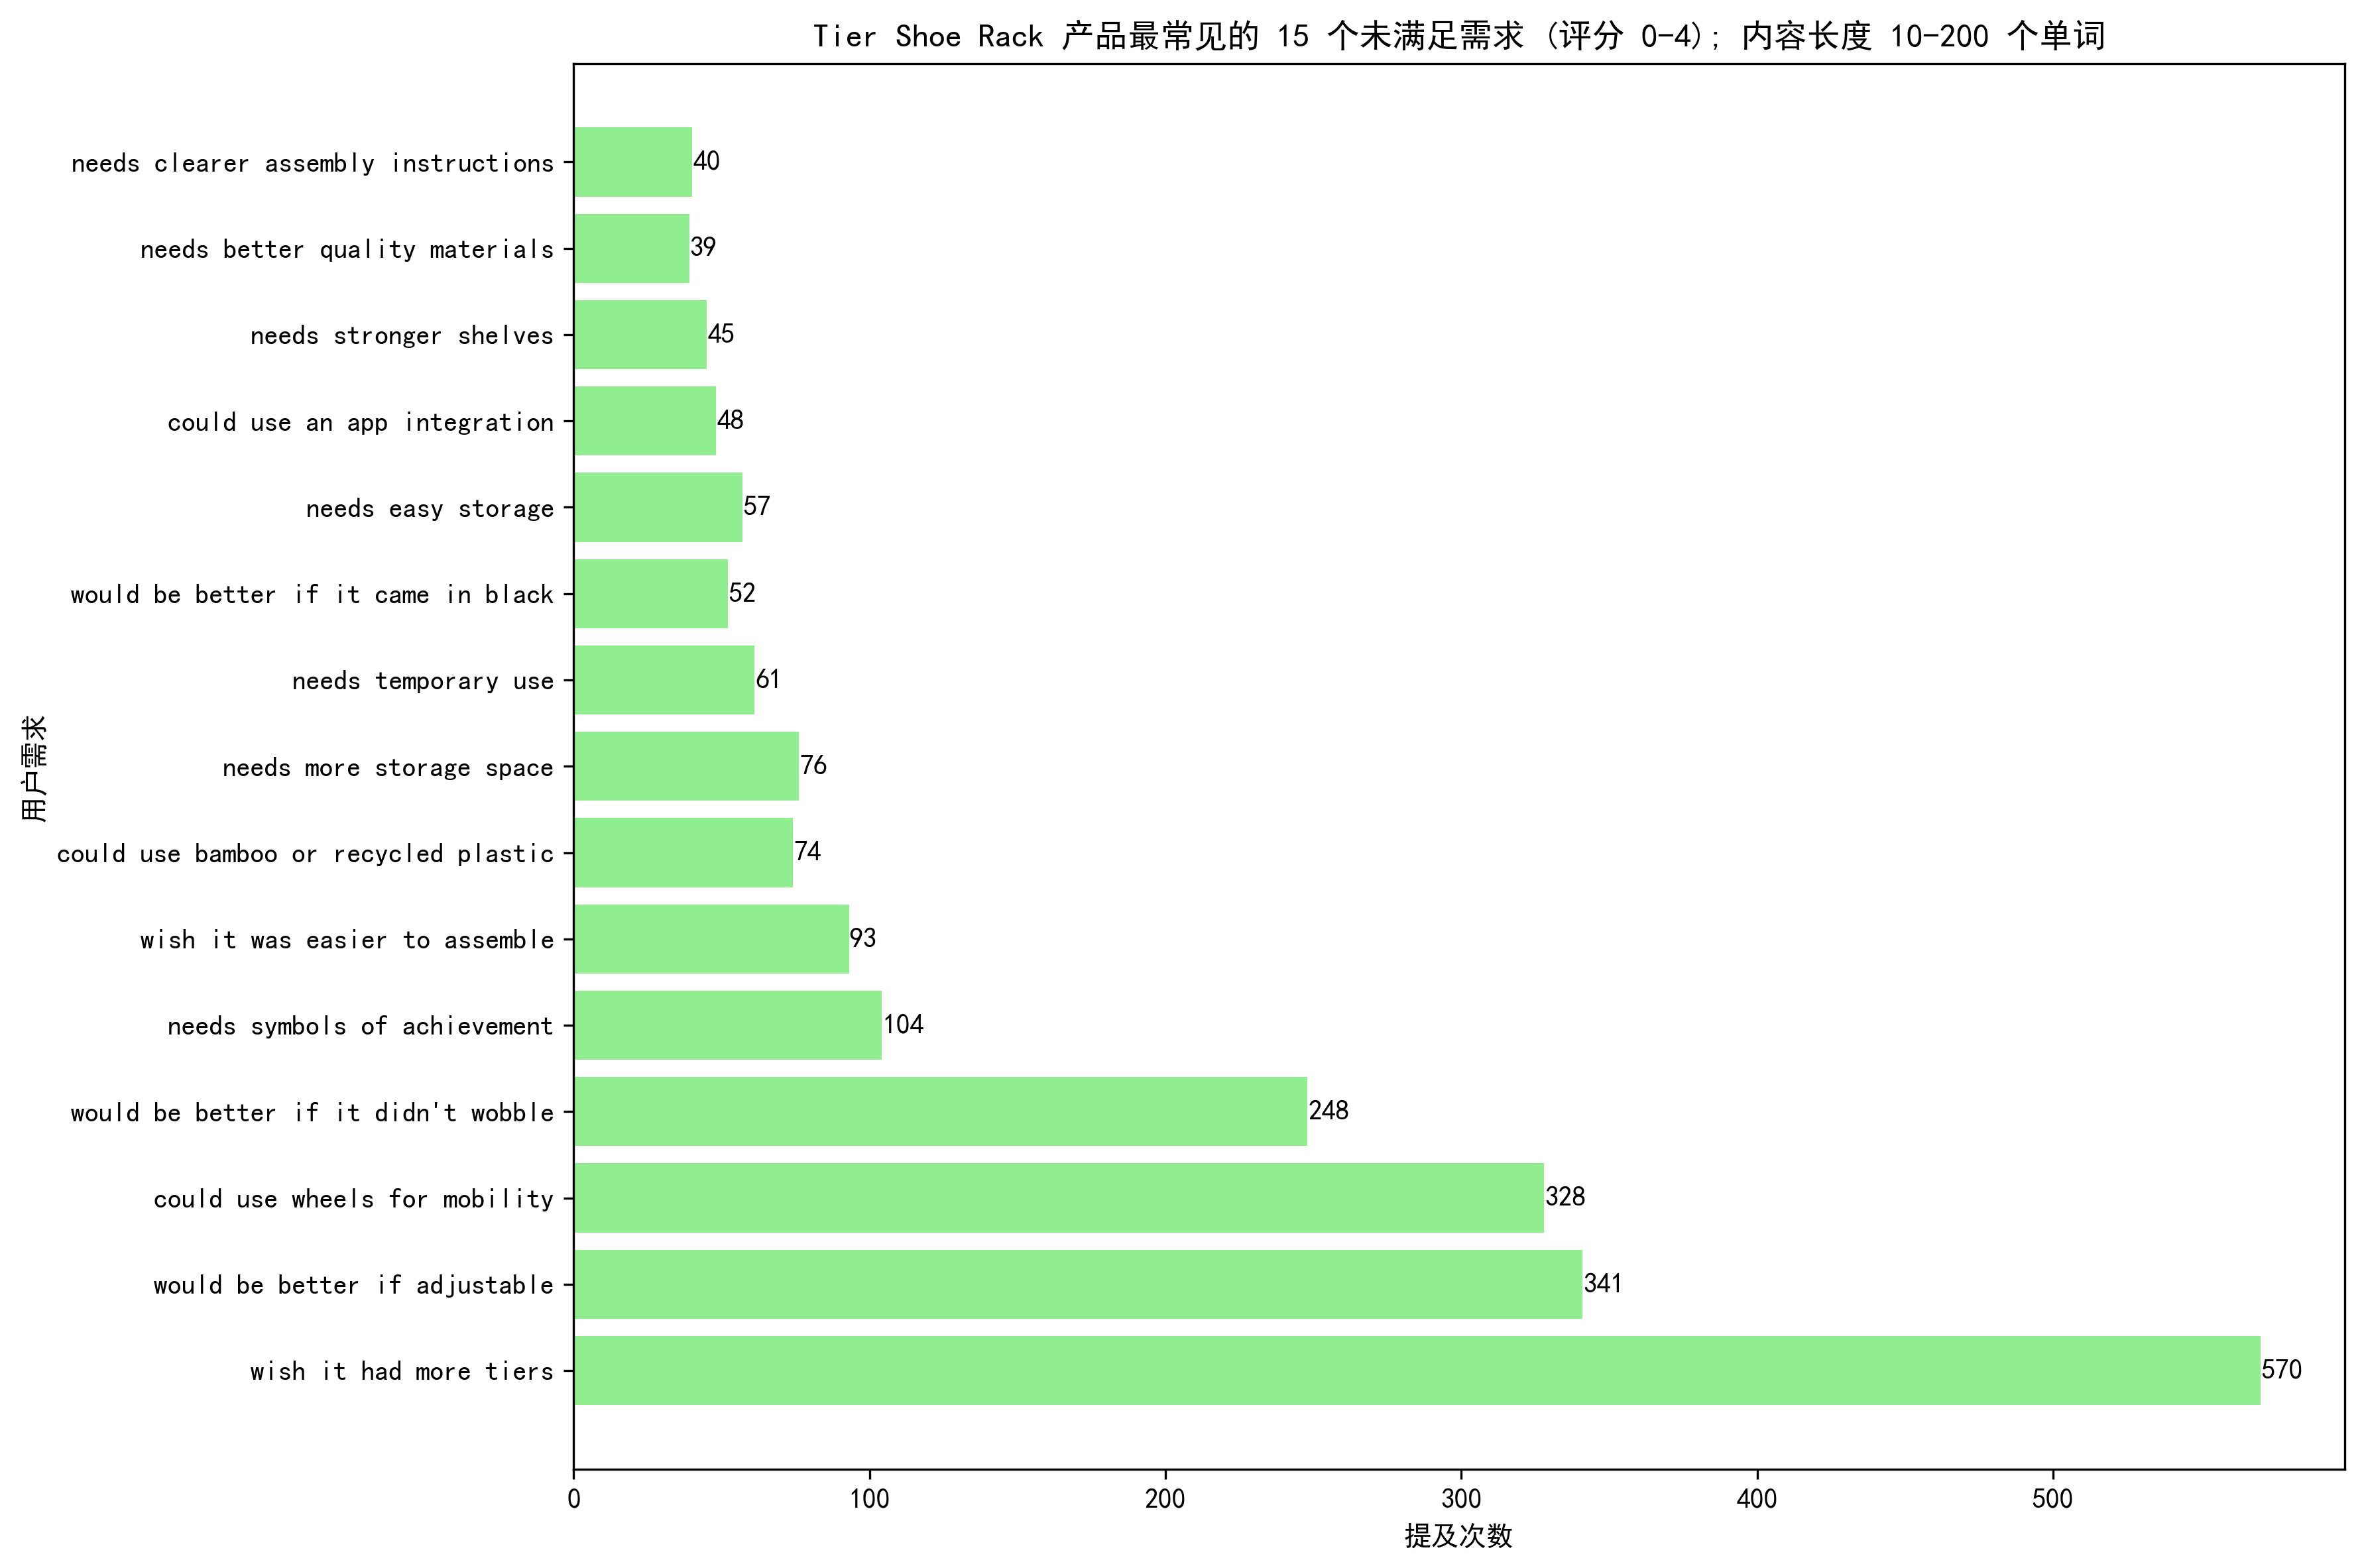


初始需求分析完成，耗时: 17.95 秒

分析条件:
- 产品类型: Tier Shoe Rack
- 评分范围: 0-4
- 内容长度: 10-200 个单词

初始需求频率分析结果:


,Need,Count,Frequency,Avg_Rating,Importance_Score,Review_Indices,ReviewText,Context
0,wish it had more tiers,570,0.189937,2.259649,559.451017,"[4, 9, 13, 19, 21, 38, 42, 47, 50, 51, 54, 56,...",[I have to be honest I'm sorry it seemed like ...,"[be honest I'm sorry it seemed like a good , A..."
1,would be better if adjustable,341,0.113629,2.170088,336.271687,"[4, 9, 19, 21, 50, 51, 56, 60, 82, 87, 91, 101...",[I have to be honest I'm sorry it seemed like ...,"[I have to be honest I'm sorry it, ieces to co..."
2,could use wheels for mobility,328,0.109297,2.310976,321.489380,"[4, 9, 38, 47, 50, 54, 56, 60, 66, 68, 82, 87,...",[I have to be honest I'm sorry it seemed like ...,"[ lasts a few days cause once you start usin, ..."
3,would be better if it didn't wobble,248,0.082639,2.322581,242.544143,"[13, 38, 42, 54, 66, 67, 69, 71, 79, 89, 96, 1...",[I received a returned item that the damaged a...,"[received a returned item that the damaged , W..."
4,needs symbols of achievement,104,0.034655,1.913462,102.144636,"[13, 42, 67, 71, 101, 124, 189, 199, 226, 236,...",[I received a returned item that the damaged a...,"[he damaged and full of black grease, his prod..."
5,wish it was easier to assemble,93,0.030990,2.172043,92.115988,"[11, 44, 68, 72, 140, 180, 189, 256, 271, 339,...",[Was skeptical about this order from jump. Sho...,"[Was skeptical about thi, no one is bumping in..."
7,could use bamboo or recycled plastic,74,0.024658,2.378378,72.456891,"[11, 67, 126, 244, 278, 284, 306, 428, 455, 54...",[Was skeptical about this order from jump. Sho...,"[keptical about this order from jump. Shoul, e..."
6,needs more storage space,76,0.025325,2.894737,69.785901,"[47, 50, 68, 82, 117, 126, 129, 145, 149, 178,...",[Smaller than the pictures make it look. It's ...,"[but in reality it's more decorative than use,..."
8,needs temporary use,61,0.020327,1.950820,58.193222,"[38, 60, 66, 89, 198, 206, 237, 416, 458, 461,...",[Was excited to use it seems sturdy but I am m...,"[Was excited to use it seems sturdy but, it th..."
10,would be better if it came in black,52,0.017328,1.826923,52.545146,"[11, 44, 72, 85, 140, 208, 271, 306, 371, 458,...",[Was skeptical about this order from jump. Sho...,"[ followed my first mind. Missing 12 poles., n..."


从原始处理结果中提取需求-评论关系，共 3001 条记录
原始needs_df的列: ['Review_Index', 'Need', 'Rating', 'ReviewText', 'Context']

初始分析结果已保存到:
分析结果: 生成结果\needs_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_10_to_200_words_needs_analysis.xlsx
图表: 生成结果\needs_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_10_to_200_words_needs_chart.png


In [16]:
import os
import sys
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from IPython.display import display
from tqdm.notebook import tqdm
import glob

# 设置基本参数
def find_voc_file():
    # 查找Data文件夹中所有以"VOC数据.xlsx"结尾的文件
    voc_files = glob.glob("Data/*VOC数据.xlsx")
    
    if voc_files:
        # 如果找到多个匹配的文件，返回最新的一个（按文件修改时间排序）
        return sorted(voc_files, key=os.path.getmtime, reverse=True)[0]
    else:
        # 如果没有找到匹配的文件，抛出错误
        raise FileNotFoundError("未找到任何以'VOC数据.xlsx'结尾的文件")

# 保持原始变量名不变
file_path = find_voc_file()
print(f"使用的文件路径: {file_path}")

with open('Data/产品类别.txt', 'r', encoding='utf-8') as f:
    product_type = f.read().strip()

# 3. 验证变量内容
print(f"product_type变量的值为: '{product_type}'")
rating_range = (0, 4)
content_length_range = (10, 200)
content_length_method = 'words'
content_column = 'content'

print("===== 第一阶段：初始需求识别 =====")
start_time = time.time()

# 读取原始数据
# 读取原始数据
try:
    print(f"尝试读取Excel文件: {file_path}...")
    try:
        # 首先尝试读取Excel文件
        original_df = pd.read_excel(file_path)
        print(f"成功读取Excel文件")
    except Exception as ex:
        print(f"读取Excel文件失败: {str(ex)}")
        print("尝试作为CSV文件读取...")
        
        # 如果Excel读取失败，尝试多种编码读取为CSV
        encodings = ['utf-8', 'gbk', 'gb18030', 'latin1']
        original_df = None
        
        for encoding in encodings:
            try:
                print(f"尝试使用 {encoding} 编码读取CSV文件...")
                original_df = pd.read_csv(file_path, encoding=encoding)
                print(f"成功使用 {encoding} 编码读取CSV文件")
                break
            except UnicodeDecodeError:
                print(f"使用 {encoding} 编码读取失败")
                continue
            except Exception as ex:
                print(f"读取时发生其他错误: {str(ex)}")
                continue
        
        if original_df is None:
            # 最后的尝试：使用errors='replace'参数
            try:
                print("尝试使用 'utf-8' 编码和 errors='replace' 参数读取CSV...")
                original_df = pd.read_csv(file_path, encoding='utf-8', errors='replace')
                print("成功读取CSV文件，但某些字符可能已被替换")
            except Exception as ex:
                print(f"所有读取方法均失败: {str(ex)}")
                sys.exit(1)
    
    print(f"原始数据包含 {len(original_df)} 条记录")
except Exception as ex:
    print(f"读取文件时发生未预期错误: {str(ex)}")
    sys.exit(1)


# 创建进度条
with tqdm(total=100, desc="正在分析产品需求") as pbar:
    def update_progress(progress):
        pbar.update(progress - pbar.n)
    
    results = analyze_product_needs(
        file_path=file_path, 
        product_type=product_type, 
        rating_range=rating_range,
        content_length_range=content_length_range,
        content_length_method=content_length_method,
        content_column=content_column,
        debug_mode=False,
        progress_callback=update_progress
    )
    
    pbar.update(100 - pbar.n)

end_time = time.time()
print(f"\n初始需求分析完成，耗时: {end_time - start_time:.2f} 秒")

# 显示筛选条件
print(f"\n分析条件:")
print(f"- 产品类型: {product_type}")
if rating_range:
    print(f"- 评分范围: {rating_range[0]}-{rating_range[1]}")
if content_length_range:
    min_len = content_length_range[0] if content_length_range[0] is not None else "任意"
    max_len = content_length_range[1] if content_length_range[1] is not None else "任意" 
    unit = "个字符" if content_length_method == "chars" else "个单词"
    print(f"- 内容长度: {min_len}-{max_len} {unit}")

print("\n初始需求频率分析结果:")
if results and results.get('success') and 'needs_stats' in results and len(results.get('needs_stats', [])) > 0:
    # 显示结果
    display(results['needs_stats'].head(10))
    
    # 创建一个映射字典，记录每个Need在哪些评论中出现
    need_to_reviews_map = {}
    
    # 首先，检查process_dataframe_for_needs函数的返回结果，这是最原始的需求-评论关系
    needs_df = results.get('needs_df')
    if isinstance(needs_df, pd.DataFrame) and len(needs_df) > 0 and 'Need' in needs_df.columns:
        print(f"从原始处理结果中提取需求-评论关系，共 {len(needs_df)} 条记录")
        
        # 检查needs_df的列
        print(f"原始needs_df的列: {needs_df.columns.tolist()}")
        
        # 从needs_df中提取需求与评论的关系
        for _, row in needs_df.iterrows():
            need = row.get('Need')
            if need:
                # 获取评论索引 - 检查可能的列名
                review_idx = None
                if 'Review_Index' in needs_df.columns:
                    review_idx = row.get('Review_Index')
                elif 'index' in needs_df.columns:
                    review_idx = row.get('index')
                
                # 获取评论文本 - 检查content_column是否存在
                review_text = None
                if content_column in needs_df.columns:
                    review_text = row.get(content_column)
                elif 'ReviewText' in needs_df.columns:
                    review_text = row.get('ReviewText')
                
                # 如果索引和文本都有效，添加到映射字典
                if review_idx is not None and review_text is not None and isinstance(review_text, str):
                    if need not in need_to_reviews_map:
                        need_to_reviews_map[need] = []
                    need_to_reviews_map[need].append((review_idx, review_text))
    
    # 处理所有输出文件
    for file_key, file_path in results['files'].items():
        if file_path and os.path.exists(file_path) and file_path.endswith('.csv'):
            # 读取CSV文件
            try:
                df = pd.read_csv(file_path, encoding='utf-8-sig')
            except:
                try:
                    df = pd.read_csv(file_path, encoding='utf-8')
                except:
                    try:
                        df = pd.read_csv(file_path, encoding='gbk')
                    except Exception as e:
                        print(f"错误: 无法读取CSV文件: {file_path}, 错误: {e}")
                        continue
            
            # 删除Context列
            if 'Context' in df.columns:
                df = df.drop(columns=['Context'])
            
            # 重新构建Review_Indices和ReviewText列
            df['Review_Indices'] = None
            df['ReviewText'] = None
            
            # 为每个需求找到匹配的评论
            if 'Need' in df.columns and 'Count' in df.columns:
                for i, row in df.iterrows():
                    try:
                        need = str(row['Need']) if not pd.isna(row['Need']) else ""
                        count = int(row['Count']) if not pd.isna(row['Count']) else 0
                        
                        # 如果need为空或count为0，填充空列表
                        if not need or count <= 0:
                            df.at[i, 'Review_Indices'] = json.dumps([])
                            df.at[i, 'ReviewText'] = json.dumps([])
                            continue
                        
                        # 首先检查映射字典中是否已有该需求的评论关系
                        matching_rows = []
                        if need in need_to_reviews_map:
                            # 使用已知的需求-评论关系
                            matching_rows = need_to_reviews_map[need]
                            print(f"从映射字典中找到需求 '{need}' 的 {len(matching_rows)} 条评论记录")
                        else:
                            # 在原始评论中搜索包含该需求的评论
                            keyword = need.lower()
                            print(f"在原始评论中搜索包含关键词 '{keyword}' 的评论")
                            
                            # 直接查找包含需求关键词的评论
                            for idx, orig_row in original_df.iterrows():
                                if content_column in orig_row and isinstance(orig_row[content_column], str):
                                    content = orig_row[content_column].lower()
                                    if keyword in content:
                                        matching_rows.append((idx, orig_row[content_column]))
                                        if len(matching_rows) >= count:
                                            break
                        
                        # 记录找到的匹配评论数量
                        found_count = len(matching_rows)
                        
                        # 如果找不到足够的匹配项，使用明确的标记
                        if found_count < count:
                            print(f"警告: 需求 '{need}' 只找到 {found_count} 条匹配评论，少于所需的 {count} 条")
                            # 不再随机填充，而是使用明确的标记
                            for _ in range(count - found_count):
                                matching_rows.append((-1, "未找到匹配评论"))
                        
                        # 确保不超过count
                        matching_rows = matching_rows[:count]
                        
                        # 提取索引和文本
                        indices = [int(row[0]) for row in matching_rows]
                        reviews = [str(row[1]) for row in matching_rows]
                        
                        # 更新DataFrame
                        df.at[i, 'Review_Indices'] = json.dumps(indices)
                        df.at[i, 'ReviewText'] = json.dumps(reviews)
                    except Exception as e:
                        print(f"错误: 处理需求'{row.get('Need', '')}' 时出错: {e}")
                        # 使用明确的错误标记
                        df.at[i, 'Review_Indices'] = json.dumps([-999] * count)  # 使用-999表示处理错误
                        df.at[i, 'ReviewText'] = json.dumps(["处理错误"] * count)
                
                # 将CSV文件路径改为Excel文件路径
                xlsx_path = os.path.splitext(file_path)[0] + ".xlsx"
                
                # 保存为Excel格式
                df.to_excel(xlsx_path, index=False)
                
                # 更新结果文件路径
                results['files'][file_key] = xlsx_path
                
                print(f"\n已处理文件: {xlsx_path}")
                print(f"- 删除了Context列(如果存在)")
                print(f"- 已填充Review_Indices和ReviewText列")
                print(f"- 当前文件包含的列: {', '.join(df.columns.tolist())}")
                
                # 验证Count与Review_Indices长度是否一致
                mismatch_count = 0
                for i, row in df.iterrows():
                    try:
                        indices = json.loads(row['Review_Indices'])
                        count = int(row['Count'])
                        if len(indices) != count:
                            mismatch_count += 1
                            if mismatch_count <= 5:  # 只显示前5个不匹配的情况
                                print(f"错误: 行 {i} 的需求 '{row['Need']}' 的索引数量({len(indices)})与Count({count})不一致")
                            elif mismatch_count == 6:
                                print("更多不匹配情况省略...")
                    except Exception as e:
                        print(f"错误: 验证行 {i} 时出错: {e}")
                
                if mismatch_count == 0:
                    print("验证完成: 所有需求的索引数量与Count一致")
                else:
                    print(f"验证完成: 发现 {mismatch_count} 个需求的索引数量与Count不一致")
    
    print(f"\n初始分析结果已保存到:")
    print(f"分析结果: {results['files'].get('result', '未知')}")
    print(f"图表: {results['files'].get('chart', '未知')}")
else:
    error_msg = results.get('error', "未知错误") if results else "分析未返回结果"
    print(f"没有找到任何用户需求信息: {error_msg}")
    print("将继续使用QWen-Max进行分析...")
    
    if not results or not results.get('success'):
        temp_dir = os.path.join("生成结果", "needs_analysis")
        os.makedirs(temp_dir, exist_ok=True)
        temp_file = os.path.join(temp_dir, f"temp_needs_analysis.xlsx")  # 改为xlsx
        
        # 创建临时DataFrame，使用明确的标记
        count_value = 1
        temp_df = pd.DataFrame({
            'Need': ['需求识别失败'],
            'Count': [count_value],
            'Frequency': [0],
            'Avg_Rating': [0],
            'Review_Indices': [json.dumps([-1] * count_value)],  # 使用-1表示未找到匹配
            'ReviewText': [json.dumps(["未找到匹配评论"] * count_value)]
        })
        temp_df.to_excel(temp_file, index=False)  # 保存为Excel格式
        
        results = {
            'needs_stats': temp_df,
            'needs_df': pd.DataFrame(),
            'files': {'result': temp_file, 'chart': None},
            'save_path': temp_file,
            'success': True
        }



===== 第二阶段：QWen-Max精确筛选 =====


QWen-Max客户端初始化成功


QWen-Max正在筛选数据:   0%|          | 0/100 [00:00<?, ?it/s]

开始精炼需求分析结果...
从文件读取完整数据: 生成结果\needs_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_10_to_200_words_needs_analysis.xlsx
从文件读取完整数据: 生成结果\needs_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_10_to_200_words_needs_analysis.xlsx
尝试读取Excel文件: 生成结果\needs_analysis\致欧-2025-01-10之后VOC数据_rating_0_to_4_length_10_to_200_words_needs_analysis.xlsx
成功读取Excel文件
成功从CSV读取的列: ['Need', 'Count', 'Frequency', 'Avg_Rating', 'Importance_Score', 'Review_Indices', 'ReviewText', 'Context']
使用QWen-Max筛选有意义的用户需求...
筛选前数据框列: ['Need', 'Count', 'Frequency', 'Avg_Rating', 'Importance_Score', 'Review_Indices', 'ReviewText', 'Context']


QWen-Max返回: [0, 2, 3, 4, 5, 7, 12, 14, 16, 18, 19, 21, 26, 28, 31, 33, 34, 37, 40, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 62, 64, 68, 71, 74, 77, 81, 82, 91, 94, 96, 100, 101, 103, 104, 105, 106, 111, 112, 113, 122, 123, 124, 139, 140, 145, 148, 158, 160, 170, 171, 172, 173, 177, 178, 182, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 201, 202, 203, 204, 205, 206, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 260, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335

,Need,Count,Frequency,Avg_Rating,Importance_Score,Review_Indices,ReviewText,Context
0,wish it had more tiers,570,0.189937,2.259649,559.451017,"[4, 9, 13, 19, 21, 38, 42, 47, 50, 51, 54, 56,...","[""I have to be honest I'm sorry it seemed like...","[""be honest I'm sorry it seemed like a good "",..."
2,could use wheels for mobility,328,0.109297,2.310976,321.489380,"[4, 9, 38, 47, 50, 54, 56, 60, 66, 68, 82, 87,...","[""I have to be honest I'm sorry it seemed like...",[' lasts a few days cause once you start usin'...
3,would be better if it didn't wobble,248,0.082639,2.322581,242.544143,"[13, 38, 42, 54, 66, 67, 69, 71, 79, 89, 96, 1...",['I received a returned item that the damaged ...,"['received a returned item that the damaged ',..."
4,needs symbols of achievement,104,0.034655,1.913462,102.144636,"[13, 42, 67, 71, 101, 124, 189, 199, 226, 236,...",['I received a returned item that the damaged ...,"['he damaged and full of black grease', 'his p..."
5,wish it was easier to assemble,93,0.030990,2.172043,92.115988,"[11, 44, 68, 72, 140, 180, 189, 256, 271, 339,...","[""Was skeptical about this order from jump. Sh...","['Was skeptical about thi', 'no one is bumping..."
7,needs more storage space,76,0.025325,2.894737,69.785901,"[47, 50, 68, 82, 117, 126, 129, 145, 149, 178,...","[""Smaller than the pictures make it look. It's...","[""but in reality it's more decorative than use..."
12,needs stronger shelves,45,0.014995,2.377778,41.937235,"[69, 108, 130, 156, 268, 282, 332, 433, 465, 5...",['Very small and picture is very deceptive. No...,"['hoe will fit on the shelves', 'oes fit well ..."
14,needs clearer assembly instructions,40,0.013329,2.400000,39.067265,"[9, 96, 114, 131, 152, 261, 413, 425, 462, 573...",['Don’t waste your money!!! I buy a LOT from A...,['nstructions for one assembly way when severa...
16,could use a top shelf,37,0.012329,2.540541,35.420413,"[51, 72, 85, 95, 101, 178, 282, 395, 475, 524,...",['The post is basically not true. It is signi...,[' some other brand’s shelfs. It fits my basi...
18,could use a polish rack,32,0.010663,1.750000,31.958507,"[203, 209, 227, 234, 268, 457, 474, 509, 512, ...",['The rack was much smaller than what was pict...,"['The rack was much smaller th', ' I’m missing..."



二次筛选的结果已保存到: 生成结果\needs_analysis\refined_致欧-2025-01-10之后VOC数据_rating_0_to_4_length_10_to_200_words_needs_analysis.xlsx


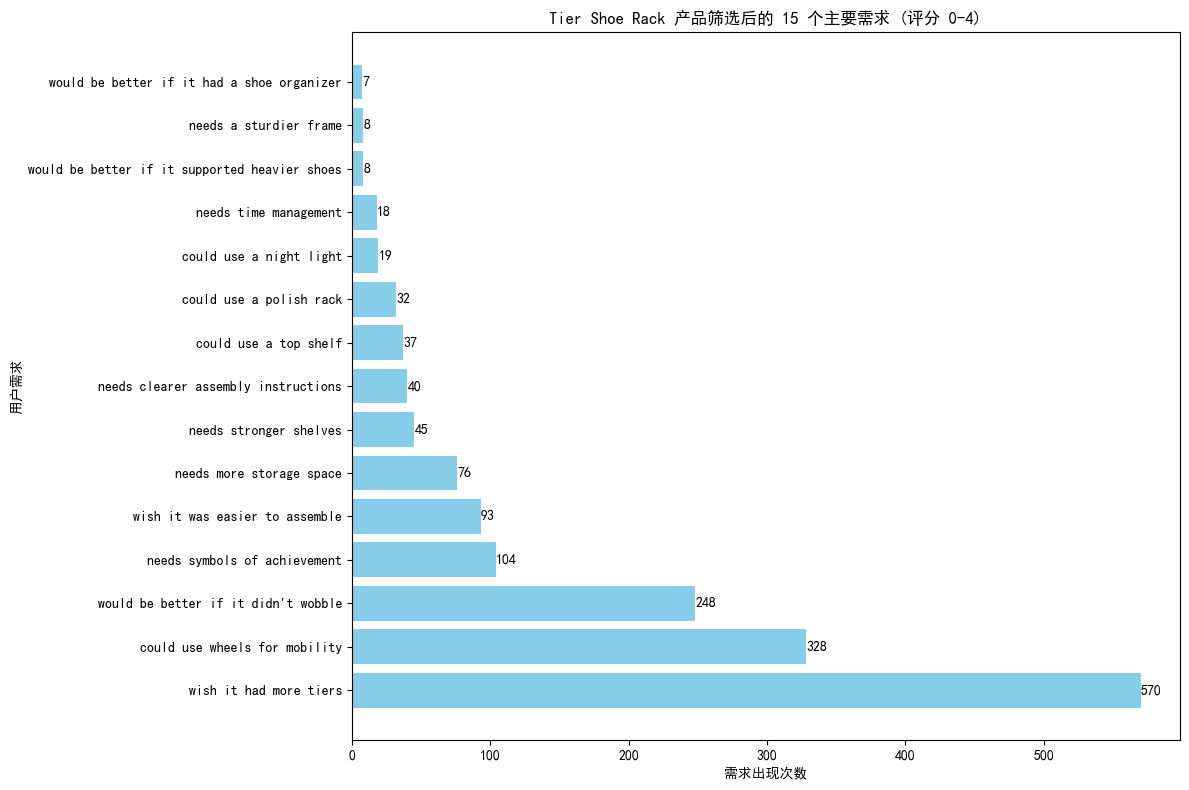

精选需求图表已保存到: 生成结果\needs_analysis\refined_致欧-2025-01-10之后VOC数据_rating_0_to_4_length_10_to_200_words_needs_analysis_chart.png

===== 需求分析流程完成 =====


In [17]:
# 步骤2: QWen-Max高级筛选
print("\n===== 第二阶段：QWen-Max精确筛选 =====")
start_time = time.time()

# 初始化QWen客户端
qwen_client = None
language = "english"  # 根据需要修改语言

try:
    # 从环境变量或配置文件中获取API密钥
    import os
    api_key = os.environ.get("QWEN_API_KEY") or API_KEY  # 假设API_KEY已在其他地方定义
    
    # 初始化OpenAI兼容的客户端
    if api_key:
        from openai import OpenAI
        qwen_client = OpenAI(
            api_key=api_key,  # 不需要引号，这是变量
            base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
        )
        print("QWen-Max客户端初始化成功")
    else:
        print("警告: 未找到API密钥，将跳过QWen-Max筛选")
        
except Exception as e:
    print(f"QWen-Max客户端初始化失败: {str(e)}")
    qwen_client = None

# 创建第二个进度条
with tqdm(total=100, desc="QWen-Max正在筛选数据") as pbar:
    # 假设refine_latest_needs_analysis函数支持回调以更新进度条
    def update_progress(progress):
        pbar.update(progress - pbar.n)
    
    refined_results = refine_latest_needs_analysis(
        results=results, 
        progress_callback=update_progress,
        qwen_client=qwen_client,
        language=language
    )
    
    # 确保进度条到达100%
    pbar.update(100 - pbar.n)

end_time = time.time()
print(f"\nQWen-Max筛选完成，耗时: {end_time - start_time:.2f} 秒")

# 显示筛选后的结果
if refined_results:
    print("\nQWen-Max筛选后的结果概览:")
    if 'needs_stats' in refined_results and refined_results['needs_stats'] is not None:
        display(refined_results['needs_stats'].head(10))  # 只显示前10条
    print(f"\n二次筛选的结果已保存到: {refined_results['save_path']}")

    # 使用'Need'和'Count'列绘制柱状图
    if 'needs_stats' in refined_results and len(refined_results['needs_stats']) > 0:
        needs_df = refined_results['needs_stats']
        
        # 确保Need和Count列存在
        if 'Need' in needs_df.columns and 'Count' in needs_df.columns:
            # 尝试获取中文字体
            try:
                for font_name in ['SimHei', 'Microsoft YaHei', 'SimSun', 'Arial Unicode MS']:
                    try:
                        font = FontProperties(family=font_name)
                        plt.rcParams['font.family'] = font_name
                        break
                    except:
                        continue
            except:
                pass  # 如果无法设置中文字体，使用默认字体
                
            # 对数据按Count列排序，取前15个
            top_n = min(15, len(needs_df))
            top_needs = needs_df.sort_values('Count', ascending=False).head(top_n)
            
            plt.figure(figsize=(12, 8))
            bars = plt.barh(top_needs['Need'], top_needs['Count'], color='skyblue')
            plt.xlabel('需求出现次数')
            plt.ylabel('用户需求')
            
            title = f'{product_type} 产品筛选后的 {top_n} 个主要需求'
            if rating_range:
                title += f' (评分 {rating_range[0]}-{rating_range[1]})'
            plt.title(title)
            
            plt.tight_layout()
            
            # 在每个条形上添加计数标签
            for bar in bars:
                width = bar.get_width()
                plt.text(width + 0.3, bar.get_y() + bar.get_height()/2, 
                         f'{width:.0f}', ha='left', va='center')
            
            # 保存精选需求图表
            refined_chart_file = os.path.splitext(refined_results['save_path'])[0] + "_chart.png"
            plt.savefig(refined_chart_file, dpi=300, bbox_inches='tight')
            
            # 显示图表
            plt.show()
            print(f"精选需求图表已保存到: {refined_chart_file}")
        else:
            print(f"警告: 无法绘制图表 - 缺少必要的列。现有列: {needs_df.columns.tolist()}")
else:
    print("QWen-Max筛选未产生有效结果")

print("\n===== 需求分析流程完成 =====")